<a id="Title"></a>


In [2]:
#always run "source ~/anaconda3/bin/activate root" before running anaconda-navigator to open this notebook

# LAB NOTEBOOK
## PROF. ANDREW C.R. MARTIN
## Project: CDR H3 Modelling Quality Prediction
### By: Lilian Denzler, Msci Student

#  

<a id="Introduction"></a>

### Introduction

Antibody modelling has come a far way in the recent decade. A great achievement has been the development of many sophisticated software programmes, such as "abYmod" written by Prof. Martin at UCL. 
The following notebook details the development of a CDR-H3 loop model quality assessor 

<b>Project aim:</b>
The aim is to have by the end of the project: 
A Quality predictor that can determine a range of RMSD in Angströms within which the input modelled structure likely falls. The predicitive power of the quality should be reasonalby high. The aim is an MCC above 0.6, ideally above 0.8. 

<b>Plan:</b>

1) Dataset creation

    --> AbDb pdb data, sequence extraction, model with abYmod

2) RMSS calculations

3) Feature set creation

4) Feature encoding

5) ML models 

    --> hyperparameter optimization,
    
    --> ensemble architecture

6) Evaluation

7) Stand-alone web-interface

8) Loop flapper

9) Integrate loop flapper with quality predictor


<a id="SetupandOrganization"></a>

### Setup and Organisation

This lab-notebook (written in Jupyter-notebook, running a bash kernel) will include be used to document the workflow of this project. In order to ensure reproducibility of results, bash shell commands will be included in the following and all used employed programs are to be found on github (https://github.com/LilianDenzler/CDR_H3_quality/tree/master)

NOTE: during the Biocomputing II lectures, where lab notebooks were discussed, this lab notebook was re-formatted in such a way that it would be executable in the notebook, rather than a collection of bash and python commands to be run in the terminal.

NOTE: following a meeting were hard-coding paths was discussed, most hard coding was replaced and a config file was added to the jupyter notebook. The directories where specific files are located can be changed depending on where the norebook is run allowing for portability. 
A virtual environment was set up (qualiloopenv), which allows for portability and compatibility with other set-ups.


<i>10.10.20</i>

After discussing the options for computer setup with Prof. Martin, I decided to opt for running a Linux OS (Ubuntu 20.04.1 LTS) in a Virtual Machine on my Windows-Laptop. I used VirtualBox (https://www.virtualbox.org/) for this and booted the VM from an external hard-drive. This enabled me to use the BASH shell without any compliations, and also gave me additional storage for any large files I didn't want to save on my laptop. 

Afterwards, I set up Git in order to track changes. I also set up a GitHub account (User: LilianDenzler) and made a new repository titled "CDR_H3_quality". Then, I synchronized Git with Github. The directory <i>/git</i> contains all files that are pushed to the repository. Prof. Martin showed me how to log into his personal server remotely, which had abYmod, bioptools and csv2arff installed on it. 


<i>14.10.20</i>

Unison was set up to sync files between the remote server and my local client. This is important for backing up data and enables me to work with large datasets, which my laptop does not have sufficient computing power for. The synced data is saved in the <i> /sync_project</i> directory. Files in the <i> /NOSYNC</i> subdirectory will not be synced.

In [1]:
#09/05/21
#The configuration file is added so that hard-coded files can be avoided.
#This config file is in the same directory as the lab notebook. The paths can be altered if needed for exectution 
#on a different machine or if folders are moved around. 
import json
from IPython import display

with open("config.json") as json_conf : 
    CONF = json.load(json_conf)

In [2]:
out=!{"abymod -h"}
print(out)

['/bin/bash: abymod: command not found']


<a id="DatasetGeneration"></a>

## 1. Dataset Generation

<i>added 02.02.21<i>
    
The first step is to produce a dataset of Antibody models, which can then be examined regarding their quality in following steps.

![alt: Workflow for Dataset creation](os.path.join(CONF["lab_book_pics"],Dataset_creation.png) "Organisation of Datasets, Scripts, Documents, etc.")

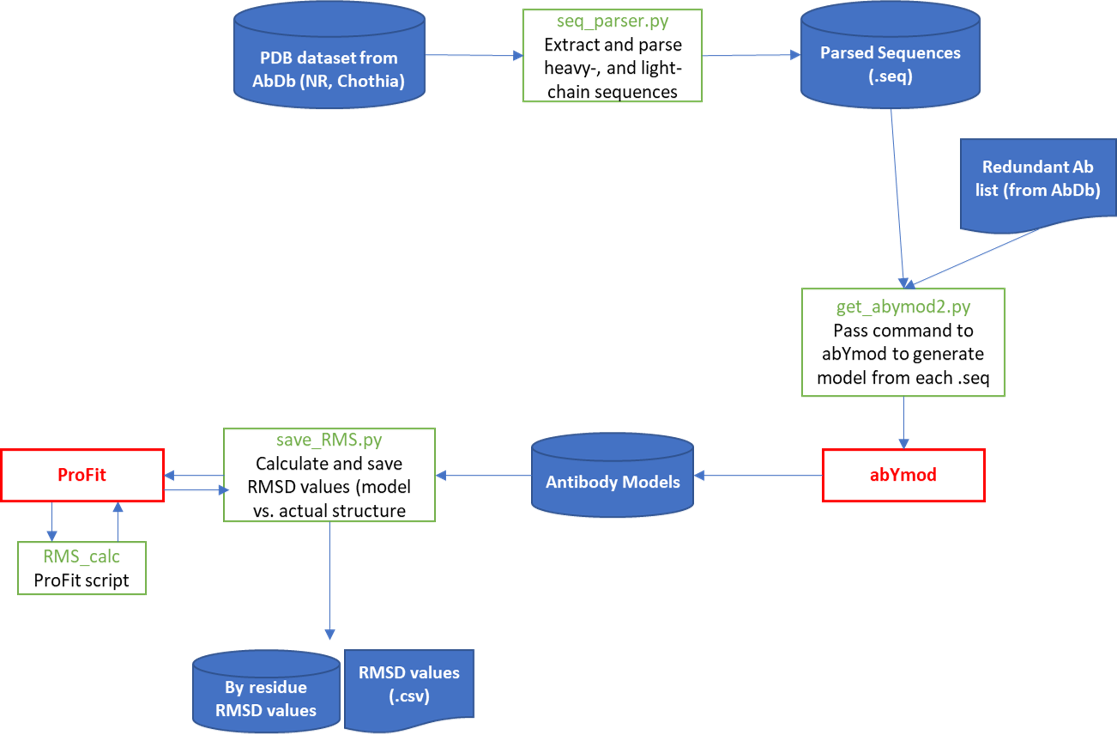

In [34]:
imgpath=str(os.path.join(CONF["lab_book_pics"],"Dataset_creation.png"))
display.Image(imgpath)

*Fig 1.* Workflow for Dataset creation

<a id="AntibodySequenceParsing"></a>

### 1.1 Antibody Sequence Parsing

<i>19.10.20</i>

The Chothia-numbered non-redundant Antibody stucture AbDb-dataset from bioinf.org.uk/abs/abdb was downloaded. The sequence of these Antibodies had to be extracted from these PDB files. To acomplish this, I wrote a short python script ("seq_parser.py"), which returned the sequence in the following abYmod-compatible format:

L1 D  
L2 I                 
L3 Q        
L4 M                 
...    
H1 F      
H2 M      
H3 T      
H4 Q     
...     

In [18]:
seq_parse=os.path.join(CONF["qualiloop_scripts"],"seq_parser.py")
input_Abymod_seq=os.path.join(CONF["input_Abymod_seq"])
actual_PDBs_NR=os.path.join(CONF["actual_PDBs_NR"])
%run $seq_parse $actual_PDBs_NR $input_Abymod_seq

this file is not in correct format (i.e. not PDB)models.fails


<a id="AbYmodModelling"></a>

### 1.2 AbYmod Modelling 

<i>31.10.20</i>

However, some of the antibodies in my newly-made dataset had redundant antibodies in the complete, redundant AbDb-dataset which is used by abYmod. I thus downloaded the textfile of PDB codes of redundant structures (also on bioinf.org.uk/abs/abdb). A python script formatted this into a dictionary. This dictionary will be used during the abYmod modelling step: For all input sequences it will be used to check if there are any redundant structures in the dataset, which will then be excluded along with the original PDB structure. This is important, as otherwise the modelling software will have an exact template and thus achieve 100% accuracy in modelling.  

The get_abYmod2.py passes a command to abYmod and saves the modelled PDB file under "<PDB_ID>.pdb.model". During the modelling process the redundant structures are excluded as templates. The template files abYmod creates during modelling (these contain,among other things, the PDB codes of the best structural template used for modelling for the CDRH3 loop and are thus of importance)are saved in a separate subdirectory as "<PDB_ID>.tpl".


In [6]:
import os 
script=os.path.join(CONF["qualiloop_scripts"],"get_abYmod2.py")
input_Abymod_seq=os.path.join(CONF["input_Abymod_seq"])
redundant_PDBs=os.path.join(CONF["redundant_PDBs"])
abYmod_structures=os.path.join(CONF["abymod_structures"])
nohup_log_path=os.path.join(CONF["nohup_logs"],"abymod.log")
#to check if abYmod is accessible from here:
out=!{"abymod -h"}
if "command not found" not in out[0]:
    print("yay")
    args = [redundant_PDBs,input_Abymod_seq,abYmod_structures]
    command="{} {} {} {}".format(script, redundant_PDBs,input_Abymod_seq,abYmod_structures)
    #out=!{command}
    #%store out > $nohup_log_path
    
else:
    print("abYmod is not accessible. The models could not be generated from here.")

#alternatively run with
#%run $script {args[0]} {args[1]} {args[2]}

#argv[1]=Redundant_PDB file; argv[2]=directory of .seq files; argv[3]=directory to save model.pdb files;
#use "nohup" so command can continue running in the background after you log out
#use "&" so it runs in background

abYmod is not accessible. The models could not be generated from here.


<a id="RMSDCalculation"></a>

### 1.3 RMSD Calculation

<i>7.11.20 & 18.11.20</i>

In order the make a judgement on the accuracy of the generated model, we will not calculate the Root Mean Square Deviation values (actal structures vs. modelled structures). 

ProFit (http://www.bioinf.org.uk/software/profit/) is used to make these calculations. The atom-to-atom RMS as well as the C-alpha atom to C-alpha atom of each residue is calculated. 
The C-alpha-atom values give a better indication of the validity of the modelled overall backbone structure. The atom values give additional information on how well the side-chains are modelled.

To determine whether the loop conformation itself is modelled incorrectly, a local calculation is performed. Here, the CDRH3 loops of the actual structure and the model are fitted onto each other.
To determine whether the loop positioning is modelled incorrectly, a global calculation is performed. The entire structure is fitted for this. 


MAKE PYMOL GRAPH TO VISUALIZE WHAT THE FITTING MEANS


In [1]:
save_RMS=os.path.join(CONF["qualiloop_scripts"],"save_RMS")
abYmod_structures=os.path.join(CONF["abymod_structures"])
actual_PDBs_NR=os.path.join(CONF["actual_PDBs_NR"])
nohup_log_path=os.path.join(CONF["nohup_logs"],"RMSD_calculations.log")
command="{} {} {}".format(save_RMS,actual_PDBs_NR,abYmod_structures)
out=!{"profit -h"}
if "command not found" not in out[0]:
    out=!{command}
    %store out > $nohup_log_path
else:
    print("ProFit is not accessible. RMSD files could not be generated")

NameError: name 'os' is not defined

We now have a single .csv file with all RMSD values for each antibody in our database. Additionally, we have a file containing the "by_residue" RMSD values for each structure. 

Moving forward, not all RMSD parameters will be used. To ensure that all RMSD values are equally informative, we check for correlation of the different RMSD-values. The tight linear positive correlation supports the assumption, that any of the RMSD value sets may be used for the preliminary machine learning model. In a meeting we decide on the  local atom-to-atom RMSD set, as it best represents the error made in the loop region. Due to the local fitting process, the loop placement (i.e angle at base is not taken into account and side-chain position is disregarded. Global AA may later be evalueated as all information on absolute loop positioning with respect to the whole structure, loop conformation and side-chain positioning converges in this single value.

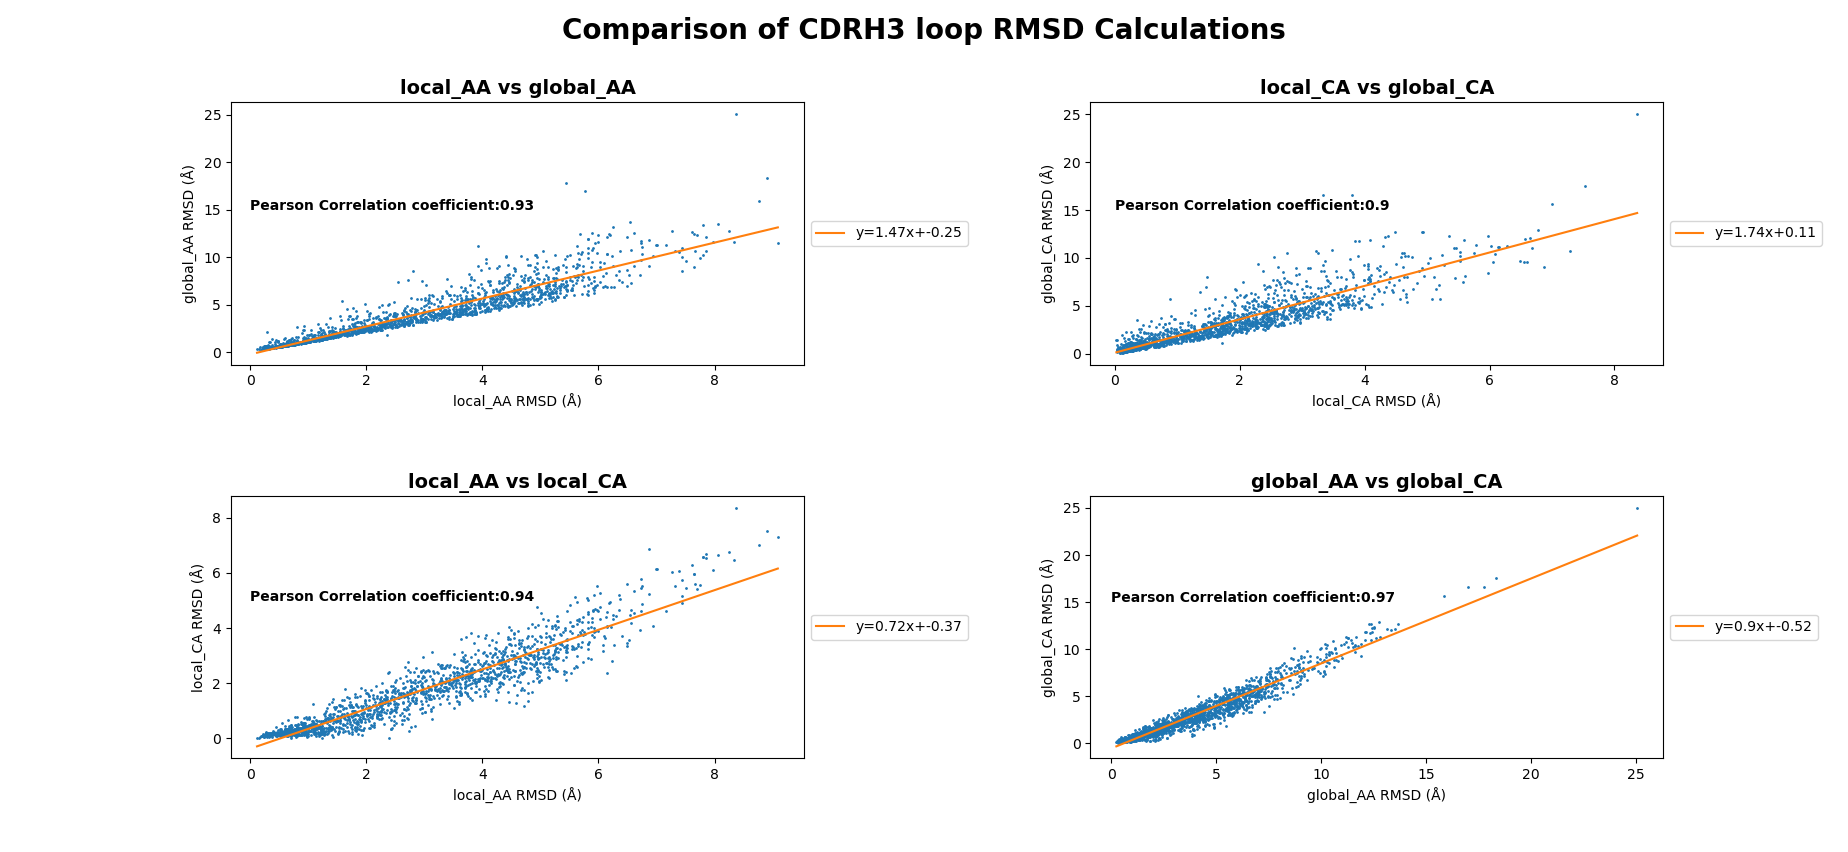

In [24]:
imgpath=str(os.path.join(CONF["lab_book_pics"],"RMSD_graph.png"))
display.Image(imgpath)

*Fig.2* This graph (plotted using the script graphs.py) shows the tight correlation of the differnet RMSD values.

The local_CA RMSD will be used going forward if not otherwise specified. 

<a id="PreliminaryModel"></a>

### 2. Preliminary Model

<i>20.11.20</i>

Before extracting many different features that may be useful for making an accuracte prediction of CDRH3 loop modelling quality we want to build a preliminary model. We will only use the loop length feature sequence identity of the template used to model the loop for this model.

It will give us a general idea of how accurate such a very basic model can be and how many features may need to be added. It is also a good opportunity to test different ML models.

Before building the model, we first need to generate a csv file containing the following information:
- Sequence identity (protein sequence of template loop vs of target sequence)
- Sequence similarity
- loop length
- PDB Code

The sequence identity and similarity is extracted from the abYmod log files. the sequences of the template and target loop are also extracted for later use. We make a csv file of sequence identity, similarity and PDB code. (We include the PDB code to ensure the feature values belong to the same modelled PDB structure.) 
First, we move the log files to a separate directory and then run the script for generating the csv file:


In [8]:
#move all of the generated log files from abYmod, which are automatically put into the abYmod structure directory.
#move it to a separate log directory

input_Abymod_seq=os.path.join(CONF["input_Abymod_seq"])
redundant_PDBs=os.path.join(CONF["redundant_PDBs"])
abYmod_structures=os.path.join(CONF["abymod_structures"])
abYmod_logs=os.path.join(CONF["abymod_logs"])
command="mv {} {}".format(os.path.join(abYmod_structures,"*.log"),abYmod_logs)
!{command}

In [18]:
import os
abYmod_logs=os.path.join(CONF["abymod_logs"])
rud_feature_extraction_path=os.path.join(CONF["qualiloop_scripts"],"rud_feature_extraction.py")
feature_dir=os.path.join(CONF["feature_dir"])
import sys
sys.path.append(rud_feature_extraction_path)

from rud_feature_extraction import similarity_score
similarity_score(feature_dir,abYmod_logs)


The loop length is then extracted from the input sequence files and aso saved as a csv file together with the PDB codes:

In [19]:
import os
input_Abymod_seq=os.path.join(CONF["input_Abymod_seq"])
rud_feature_extraction_path=os.path.join(CONF["qualiloop_scripts"],"rud_feature_extraction.py")
feature_dir=os.path.join(CONF["feature_dir"])
import sys
sys.path.append(rud_feature_extraction_path)

from rud_feature_extraction import get_loop_length
get_loop_length(feature_dir,input_Abymod_seq)


We will then merge the two csv files we have just made with each other and with the RMSD value file.
on the 'ID' column. This ensures that each feature is matches to it's correct structure. 

In [7]:
import os
import pandas as pd
input_Abymod_seq=os.path.join(CONF["input_Abymod_seq"])
rud_feature_extraction_path=os.path.join(CONF["qualiloop_scripts"],"rud_feature_extraction.py")
feature_dir=os.path.join(CONF["feature_dir"])
RMS_csv=os.path.join(feature_dir,"RMS_feature_csv" + ".csv")
length_csv=os.path.join(feature_dir,"length.csv")
seq_id_csv=os.path.join(feature_dir,"seq_id.csv")

RMS_csv_df = pd.read_csv(RMS_csv, header=0,sep=',')
length_csv_df=pd.read_csv(length_csv, header=0,sep=',')
merged = RMS_csv_df.merge(length_csv_df, on='ID')
seq_id_csv_df = pd.read_csv(seq_id_csv, header=0,sep=',')
merged = merged.merge(seq_id_csv_df, on='ID')
merged.to_csv(os.path.join(feature_dir,"rudimentary_features"+".csv"), index=False)


We then need to preprocess the file. We will delete all rows in the csv file that don't have an RMSD-value, seeing as without this parameter the instance is useless for training or testing the model. 

In [10]:
import os
import sys
loop_duplicates_path=os.path.join(CONF["qualiloop_scripts"],"loop_duplicates.py")
sys.path.append(loop_duplicates_path)
feature_dir=os.path.join(CONF["feature_dir"])
rud_features_csv=os.path.join(feature_dir,"rudimentary_features"+".csv")
from loop_duplicates import check_empty
check_empty(rud_features_csv)

From  1668 rows,  19  rows will be deleted


Furthermore, we check for redundancy in the loop sequences. There are about 400 instances which have a non-unique loop sequence. For the preliminary model we will delete all additional data instances, so that every row in our .csv file will have a unique loop sequence. 
This is important because all of our features (length and sequence identity/similarity) are taken from the sequence directly. Thus, the entire data instance will be identical if two structures share a loop sequence (only to be discerend via PDB code). Keeping this data instances in the dataset will skew the weighting when building the model.
Later on, when features taken from sources other than the sequence directly, these data instances will be added back in. 

In [2]:
import os
import sys
loop_duplicates_path=os.path.join(CONF["qualiloop_scripts"],"loop_duplicates.py")
sys.path.append(loop_duplicates_path)
feature_dir=os.path.join(CONF["feature_dir"])
input_Abymod_seq=os.path.join(CONF["input_Abymod_seq"])
rud_features_csv=os.path.join(feature_dir,"rudimentary_features"+".csv")
from loop_duplicates import check_redundancy
check_redundancy(rud_features_csv, input_Abymod_seq)

/home/lilian/sync_project/WWW/CDRH3loop/CDRH3loop/feature_dir/rudimentary_features.csv


We then convert this csv file into an .arff file, which is the input file type for weka.

In [22]:
feature_dir=os.path.join(CONF["feature_dir"])
rud_features_csv=os.path.join(feature_dir,"rudimentary_features"+".csv")
rud_features_arff=os.path.join(feature_dir,"rudimentary_features"+".arff")
![csv2arff -inputs=identity,similarity,length global_AA $rud_features_csv > $rud_features_arff]

/bin/bash: [csv2arff: command not found


### 2.1Weka experimentation

<i>26.11.21</i>

This arff input file can now be used in weka (https://www.cs.waikato.ac.nz/ml/weka/). 

I find weka ideal to explore the  dataset and get a feel for what works and what doesn't work in a very short amount of time with minimal coding required if the explorer GUI is used. Here different methods such as Random-Forest Classifiers, Multilayer Perceptrons, Linear Regression, etc. are tested. These tests are not done systematically, but are rather there to get a feel for the data at this early stage. 

First, a baseline is established using ZeroR. The results show no correlation, which is wanted.

Using k-fold cross-validation (k=10) for evalutating the model:


------------------------------------------------------------
Correlation coefficient                 -0.0637

Mean absolute error                      1.1347

Root mean squared error                  1.3936

Relative absolute error                  100%

Root relative squared error              100%

Total Number of Instances                1649 

Ignored Class Unknown Instances          19 

--------------------------------------------------------------


A Multilayer Perceptron Network (type of NN) is built with 2 hidden layers (2 and 1 nodes) using the Explorer GUI. The results are as follows using 10-fold cross-validation:

-----------------------------------------------
Correlation coefficient                  0.6889


Mean absolute error                      0.8166


Root mean squared error                  1.0626


Relative absolute error                 71.9667 %


Root relative squared error             76.2494 %

-----------------------------------------------------



Using linear regression: (ALL CLASSES)

-----------------------
Correlation coefficient                  0.75  

Mean absolute error                      0.6942

Root mean squared error                  0.9012

Relative absolute error                 65.198  %

Root relative squared error             66.0426 %

Total Number of Instances             1419

---------------------------------


Using a Random Forest predictor (numerical, not a classifier) (ALL CLASSES)

--------------------
Correlation coefficient                  0.8237

Mean absolute error                      0.5781

Root mean squared error                  0.775

Relative absolute error                 54.2912 %

Root relative squared error             56.7891 %

Total Number of Instances             1419

---------------


Note: The error is always significantly lower on a training set vs on a test-set (30/70 split). ALso the correlation is ca. 0.2 greater in all cases except zeroR. This may indicate the model can't generalize well

Weka can also be run via the command line:

In [ ]:
#export CLASSPATH="/home/amartin/weka-3-8-3/weka.jar"

#java weka.classifiers.functions.MultilayerPerceptron  -t ~/sync_project/Feature/length_RMS_seqId.arff   -d ~/sync_project/Feature/length_RMS_seqId.model   >H~/sync_project/Feature/length_RMS_seqId.out

<a id="FeatureExtraction"></a>

### 3. Feature Extraction

Feature extraction is the central part to this project. It determines how well our model can learn. Many different features can be extracted. 
I have decided to structure these diffenet calculations as a python package. A top-layer file will call on various different modules saved in the package. Each module has the task of calculating a single feature, althrough some features yield more than one result value (i.e. Hydrophobicity module also gives the different of Hydrophobicity to template sequence, etc.)



#### 3.0 Create Full Dataset

<i> 12.12.20</i>

First import the myfunctions module which acts as a library containing the functions we need for dataset creation


In [3]:
import os
myfunctions=os.path.join(CONF["qualiloop_scripts"],"myfunctions.py")
import sys
sys.path.append(myfunctions)
from myfunctions import *

In [4]:
import os

abYmod_logs=os.path.join(CONF["abymod_logs"])
myfunctions=os.path.join(CONF["qualiloop_scripts"],"myfunctions.py")
feature_dir=os.path.join(CONF["feature_dir"])
input_Abymod_seq=os.path.join(CONF["input_Abymod_seq"])
redundant_PDBs=os.path.join(CONF["redundant_PDBs"])
abYmod_structures=os.path.join(CONF["abymod_structures"])
input_Abymod_seq=os.path.join(CONF["input_Abymod_seq"])
actual_PDBs_NR=os.path.join(CONF["actual_PDBs_NR"])

import sys
######################################
#making abYmod models using myfunctions library
for file in os.listdir(actual_PDBs_NR):
    ID=file.replace(".pdb", "")
    print(ID)
    file=os.path.join(actual_PDBs_NR,file)
    model_path,log_path=get_models(abYmod_structures, ID, file,Redundant_PDBs=redundant_PDBs)

4F57_1
/home/lilian/sync_project/abymod_structures2/4F57_1_input.csv
abymod -v=4 -excl100 -exclude= -autoexclude /home/lilian/sync_project/abymod_structures2/4F57_1_input.csv > /home/lilian/sync_project/abymod_structures2/4F57_1.pdb.model 2>/home/lilian/sync_project/abymod_structures2/4F57_1.log
6A67_1
/home/lilian/sync_project/abymod_structures2/6A67_1_input.csv
abymod -v=4 -excl100 -exclude=6A67_2 -autoexclude /home/lilian/sync_project/abymod_structures2/6A67_1_input.csv > /home/lilian/sync_project/abymod_structures2/6A67_1.pdb.model 2>/home/lilian/sync_project/abymod_structures2/6A67_1.log
6BF4_1
/home/lilian/sync_project/abymod_structures2/6BF4_1_input.csv
abymod -v=4 -excl100 -exclude=6BF4_2 -autoexclude /home/lilian/sync_project/abymod_structures2/6BF4_1_input.csv > /home/lilian/sync_project/abymod_structures2/6BF4_1.pdb.model 2>/home/lilian/sync_project/abymod_structures2/6BF4_1.log
6EV2_1
/home/lilian/sync_project/abymod_structures2/6EV2_1_input.csv
abymod -v=4 -excl100 -exclud

KeyboardInterrupt: 

In [17]:
full_dataset=pd.DataFrame()
for file in os.listdir(abYmod_structures):
    ID=file.replace(".pdb", "")
    print(ID)
    file=os.path.join(abYmod_structures,file)
    row=run(file,list_of_features=None,template=None, log_path=os.path.join(abYmod_logs,ID+".log"))
    full_dataset=pd.concat([full_dataset, pd.DataFrame(row)], ignore_index=True)
    
full_dataset.to_csv(os.path.join(feature_dir,"full_features.csv"))

3V6O_1.model
SEQ HDGDY
SEQ HDGDY
Empty DataFrame
Columns: []
Index: []
         seq  length
0  HDGHETMDY       9
None
   total_charge  nr_charged
0          -2.0           5
Empty DataFrame
Columns: []
Index: []
  tip_pos tip_res  protrusion
0     101       D    5.331034
   Hydropathy
0        -2.6
  Access Relacc Scacc Screlacc Access_avg Relacc_avg Scacc_avg Screlacc_avg
0   None   None  None     None       None       None      None         None
  critical_seq
0        HDGDY
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
6C5H_1.model
Empty DataFrame
Columns: []
Index: []
  seq  length
0           0
None
   total_charge  nr_charged
0             0           0
Empty DataFrame
Columns: []
Index: []
  tip_pos tip_res protrusion
0    None    None       None
   Hydropathy
0           0
  Access Relacc Scacc Screlacc Access_avg Relacc_avg Scacc_avg Screlacc_avg
0   None   None  None     None       None       None      None  

SEQ GSHAI
SEQ GSHAI
Empty DataFrame
Columns: []
Index: []
            seq  length
0  GSHLYPNDALAI      12
None
   total_charge  nr_charged
0          -0.5           2
Empty DataFrame
Columns: []
Index: []
  tip_pos tip_res  protrusion
0      99       Y     8.45845
   Hydropathy
0        0.38
  Access Relacc Scacc Screlacc Access_avg Relacc_avg Scacc_avg Screlacc_avg
0   None   None  None     None       None       None      None         None
  critical_seq
0        GSHAI
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
3BZ4_1.model
Empty DataFrame
Columns: []
Index: []
  seq  length
0           0
None
   total_charge  nr_charged
0             0           0
Empty DataFrame
Columns: []
Index: []
  tip_pos tip_res protrusion
0    None    None       None
   Hydropathy
0           0
  Access Relacc Scacc Screlacc Access_avg Relacc_avg Scacc_avg Screlacc_avg
0   None   None  None     None       None       None      None         

KeyboardInterrupt: 

In [7]:
import os
import pandas as pd
abYmod_logs=os.path.join(CONF["abymod_logs"])
myfunctions=os.path.join(CONF["qualiloop_scripts"],"myfunctions.py")
feature_dir=os.path.join(CONF["feature_dir"])
feature_csv=os.path.join(feature_dir,"full_features.csv")
f=pd.read_csv(feature_csv)
print(f.head())

   Unnamed: 0  identity  similarity            seq  length  simlength  \
0           0     0.846       0.867  RAHNVVLGDWFAY      13   0.066692   
1           1     0.462       0.415  PYPNDGMSWYFDL      13   0.031923   
2           2     0.500       0.389         GQGRPY       6   0.064833   
3           3     0.900       0.917     GTSGYDYFDY      10   0.091700   
4           4     0.556       0.380      NYGSDSLDY       9   0.042222   

   total_charge  nr_charged  Happiness_mean  Nr_sad  ... Screlacc_avg  \
0           0.5           3           0.769     2.0  ...    26.085538   
1          -2.0           2           0.905     0.0  ...    19.187231   
2           1.0           1           0.852     1.0  ...    24.471667   
3          -2.0           2           0.892     0.0  ...    21.957500   
4          -2.0           2           0.849     0.0  ...    22.409667   

  critical_seq  blosum_dist  contacts_all  contacts_out  \
0        RAHAY    -9.509775          21.0           8.0   
1   

This script calculates the features for each file and outputs one row per structure.

In order to combine these rows into a full datframe, a seperate function in created. 

modelmaker.py is a library created for automating dataset creating from the AbDb databse and calculating all necessary features. 

In [7]:
import os
modelmaker=os.path.join(CONF["qualiloop_scripts"],"modelmaker.py")
import sys
sys.path.append(modelmaker)
from modelmaker import *

#### 3.1. Loop Length

CDRH3 loop length is a very simple predictor, yet very effective. The longer the loop the higher the RMSD is likely to be.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


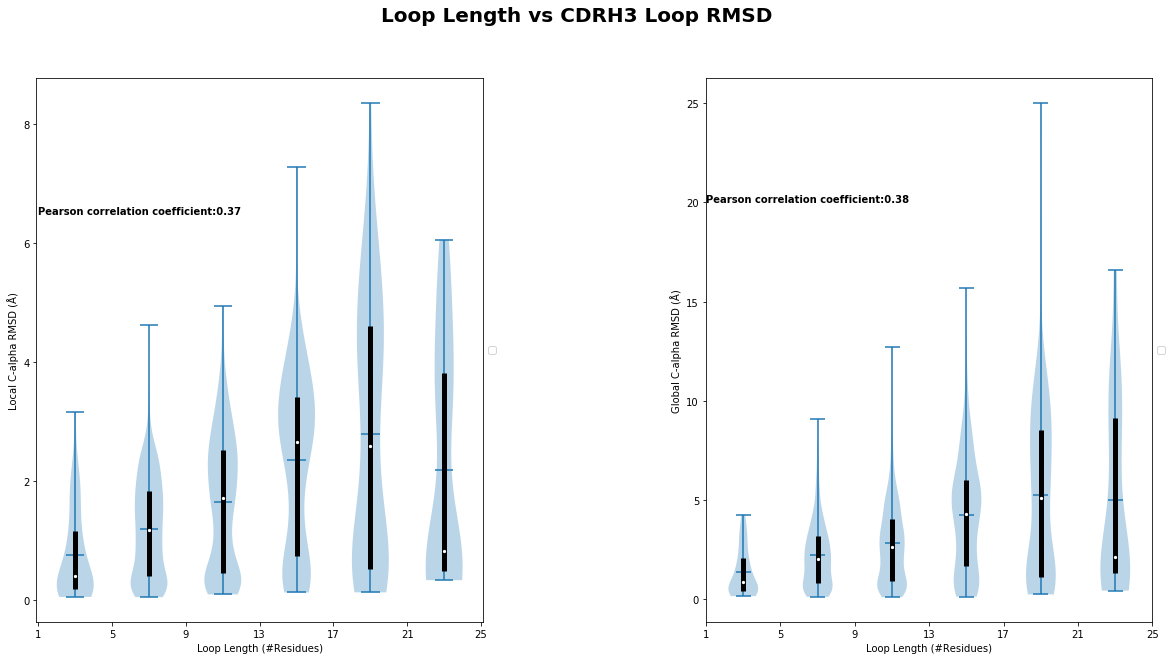

In [2]:
import os
abYmod_logs=os.path.join(CONF["abymod_logs"])
myfunctions=os.path.join(CONF["qualiloop_scripts"],"myfunctions.py")
feature_dir=os.path.join(CONF["feature_dir"])
feature_csv=os.path.join(feature_dir,"full_features.csv")
import sys

viz_script=os.path.join(CONF["qualiloop_scripts"],"length_vs_RMSD_violin.py")
from length_vs_RMSD_violin import plot_graph
plot_graph(feature_csv)


#### 3.2. Template sequence, Identity and Similarity

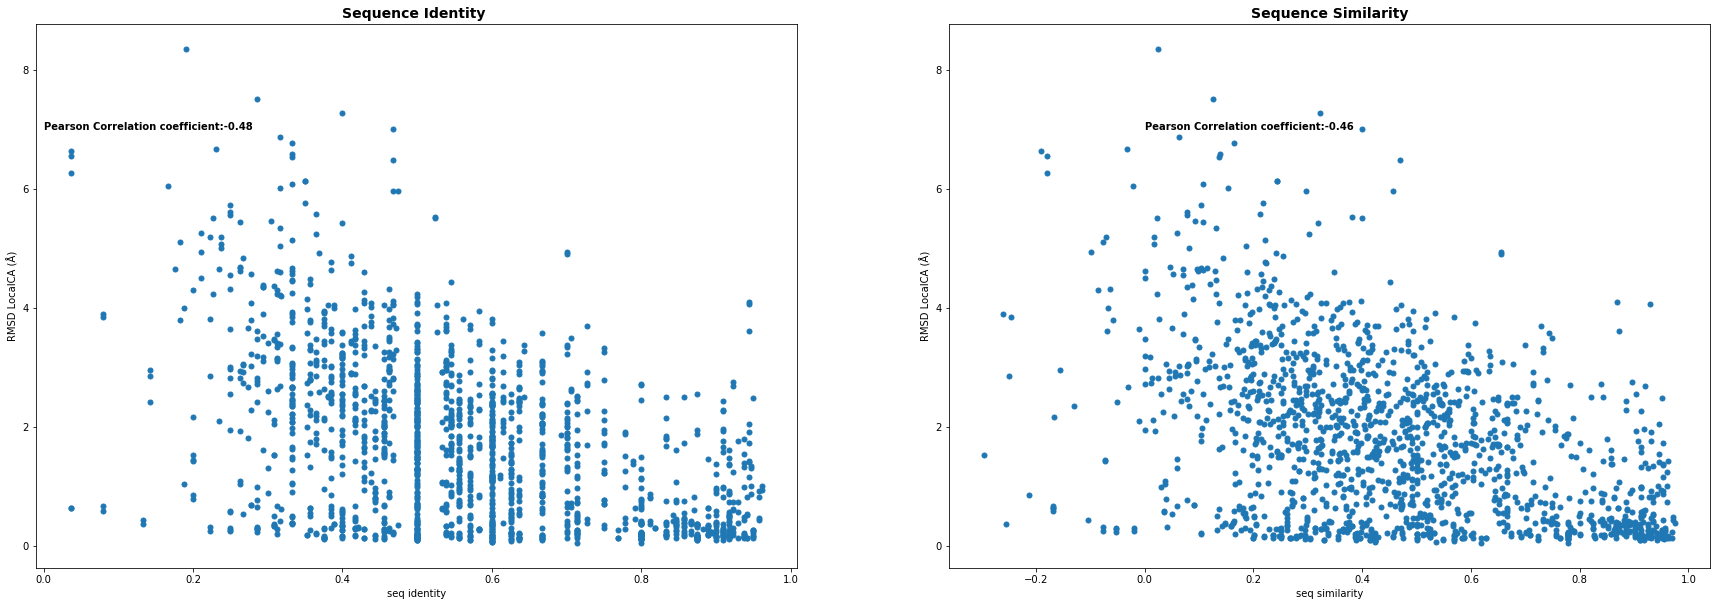

In [3]:
import os
abYmod_logs=os.path.join(CONF["abymod_logs"])
myfunctions=os.path.join(CONF["qualiloop_scripts"],"myfunctions.py")
feature_dir=os.path.join(CONF["feature_dir"])
feature_csv=os.path.join(feature_dir,"full_features.csv")
import sys

viz_script=os.path.join(CONF["qualiloop_scripts"],"seqId_similarity_vs_RMSD.py")
from seqId_similarity_vs_RMSD_violin import plot_graph
plot_graph(feature_csv)


As can be seen in the graphs above both fetaures correlate highly with local CA RMSD. (identity: -0.48, similarity: -0.46) 

#### 3.2. Charge

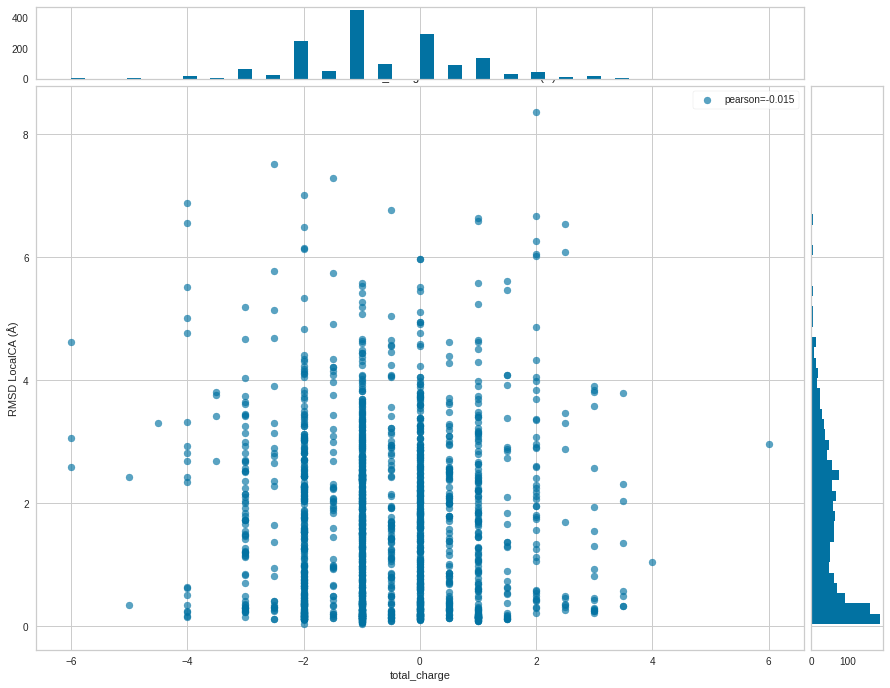

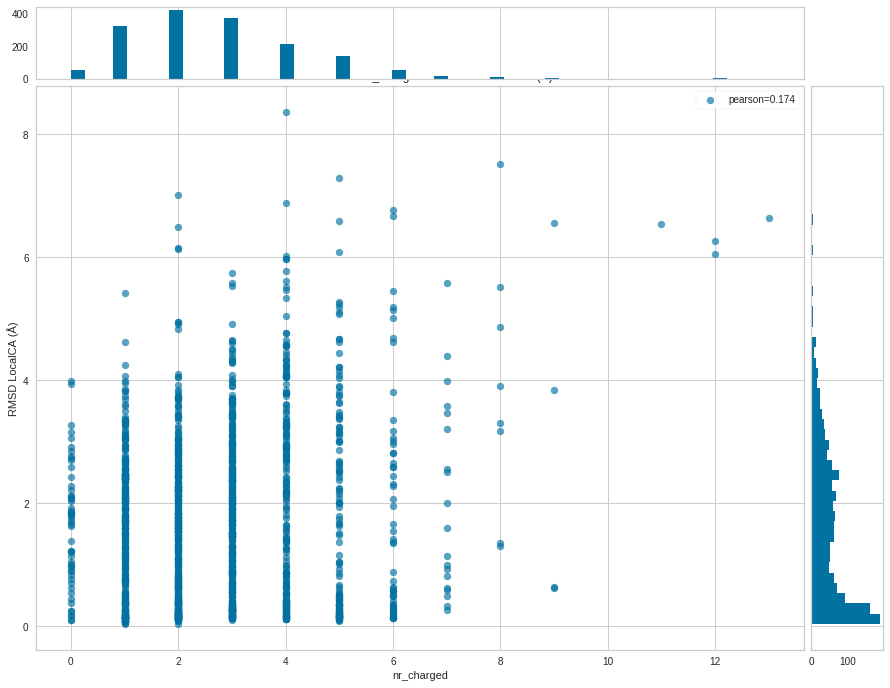

In [2]:
import os
abYmod_logs=os.path.join(CONF["abymod_logs"])
myfunctions=os.path.join(CONF["qualiloop_scripts"],"myfunctions.py")
feature_dir=os.path.join(CONF["feature_dir"])
feature_csv=os.path.join(feature_dir,"full_features.csv")
import sys

viz_script=os.path.join(CONF["qualiloop_scripts"],"grapher.py")
from grapher import plot_graph
plot_graph(feature_csv,"total_charge")
plot_graph(feature_csv,"nr_charged")

#### 3.3. Hydrophobicity

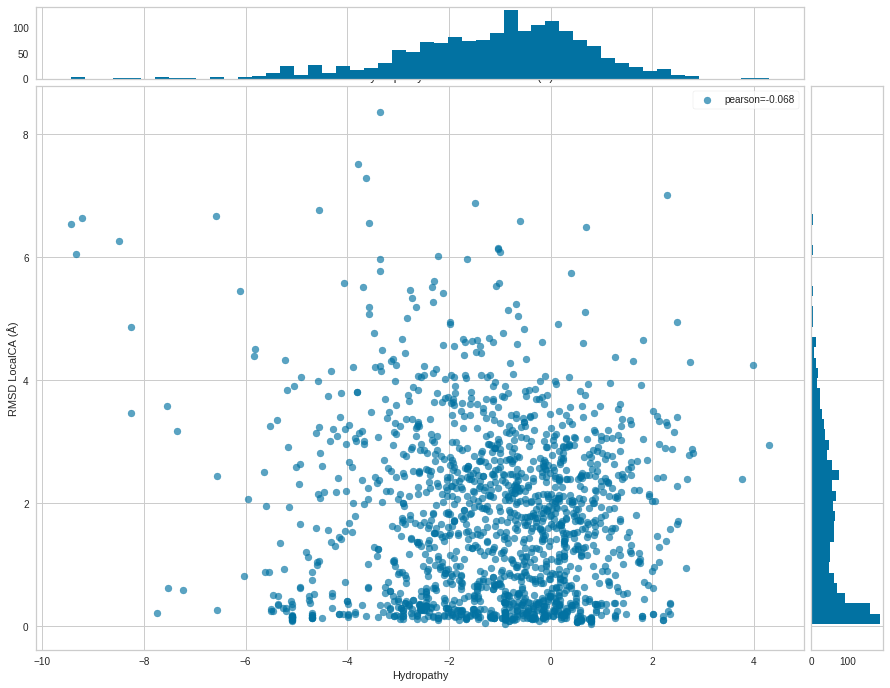

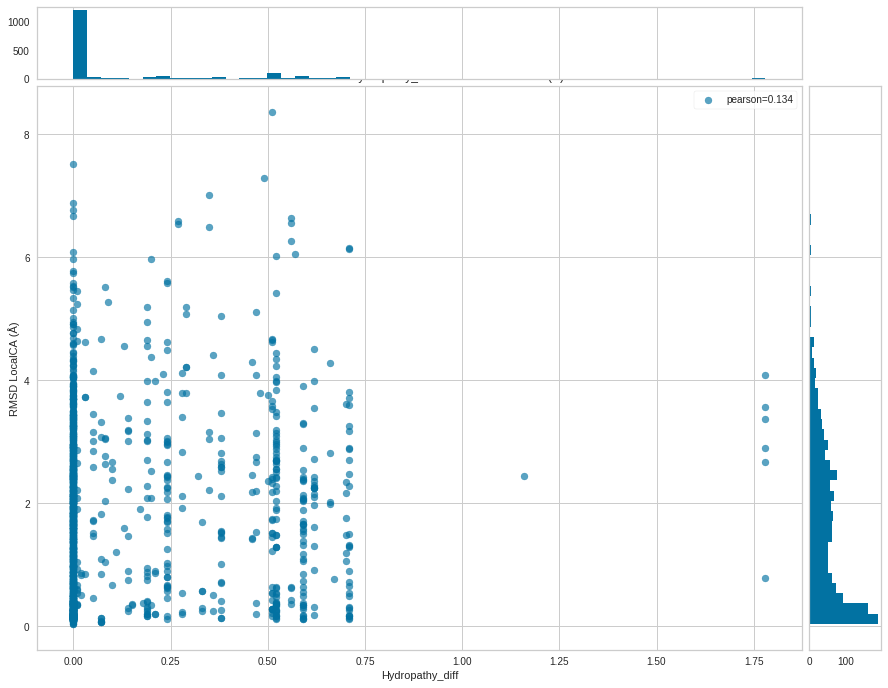

In [6]:
import os
abYmod_logs=os.path.join(CONF["abymod_logs"])
myfunctions=os.path.join(CONF["qualiloop_scripts"],"myfunctions.py")
feature_dir=os.path.join(CONF["feature_dir"])
feature_csv=os.path.join(feature_dir,"full_features.csv")
import sys

viz_script=os.path.join(CONF["qualiloop_scripts"],"grapher.py")
from grapher import plot_graph
plot_graph(feature_csv,"Hydropathy")
plot_graph(feature_csv,"Hydropathy_diff")

#### 3.4. Accessibility

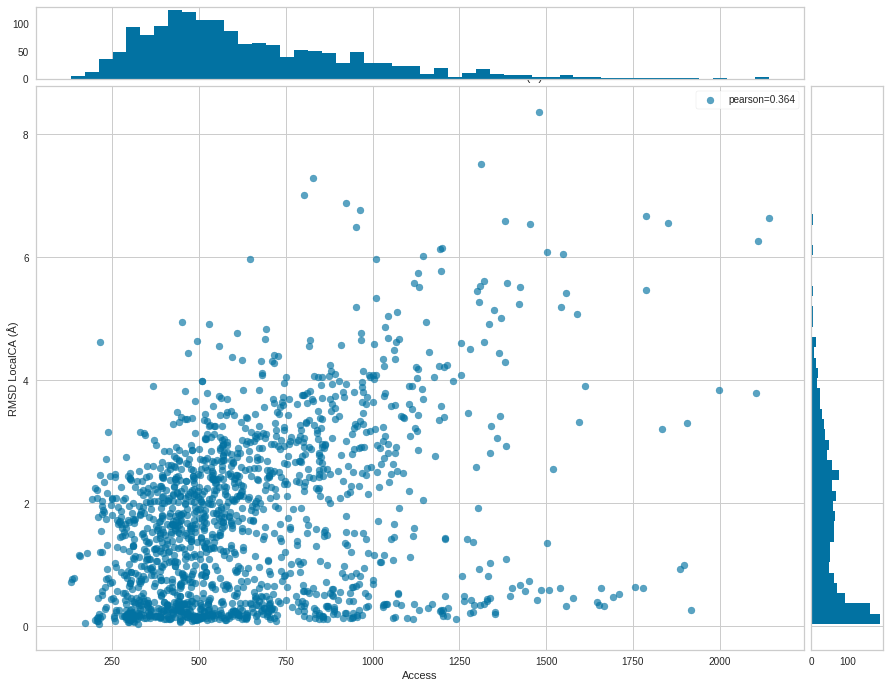

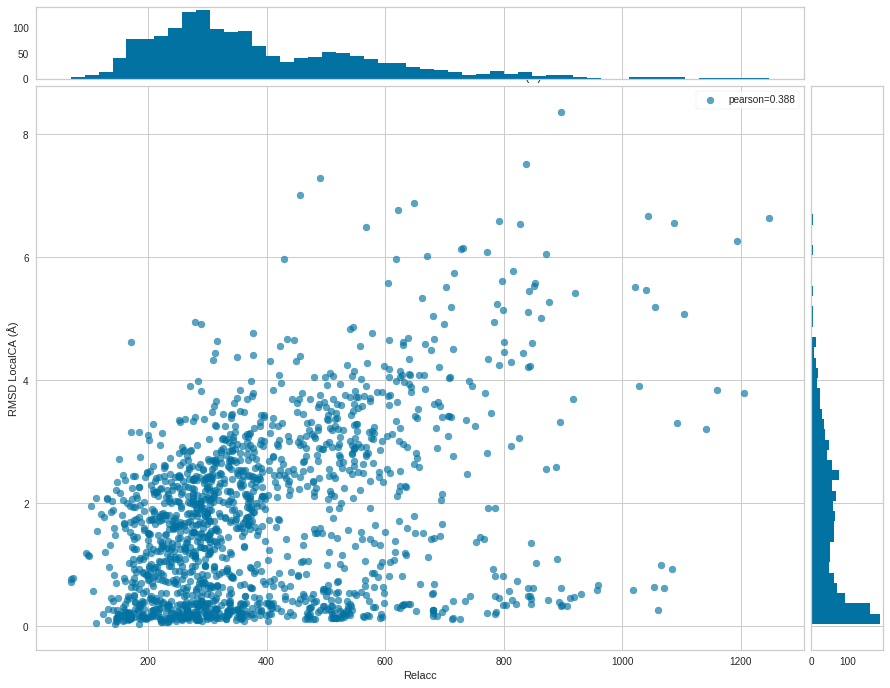

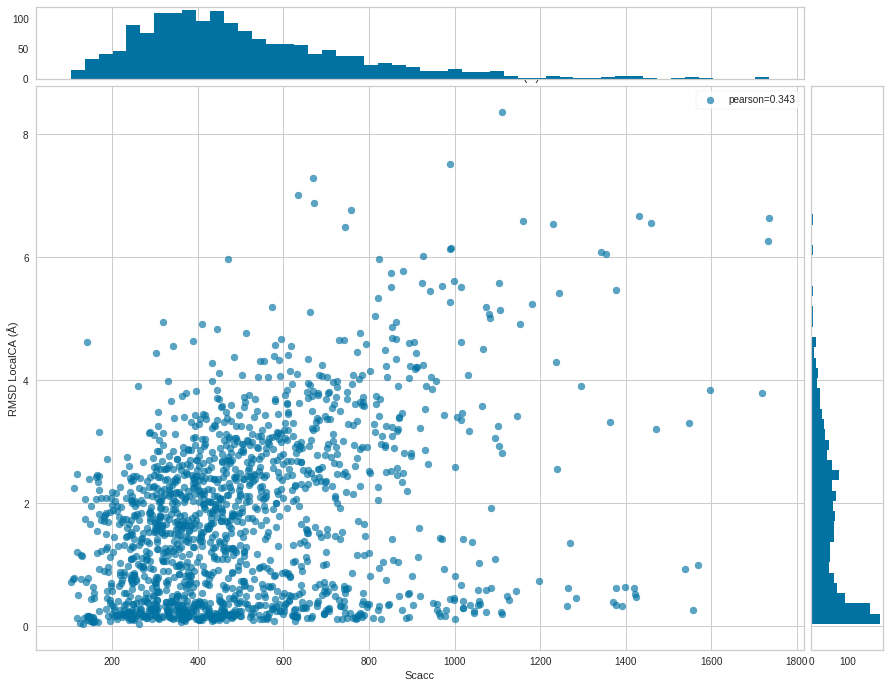

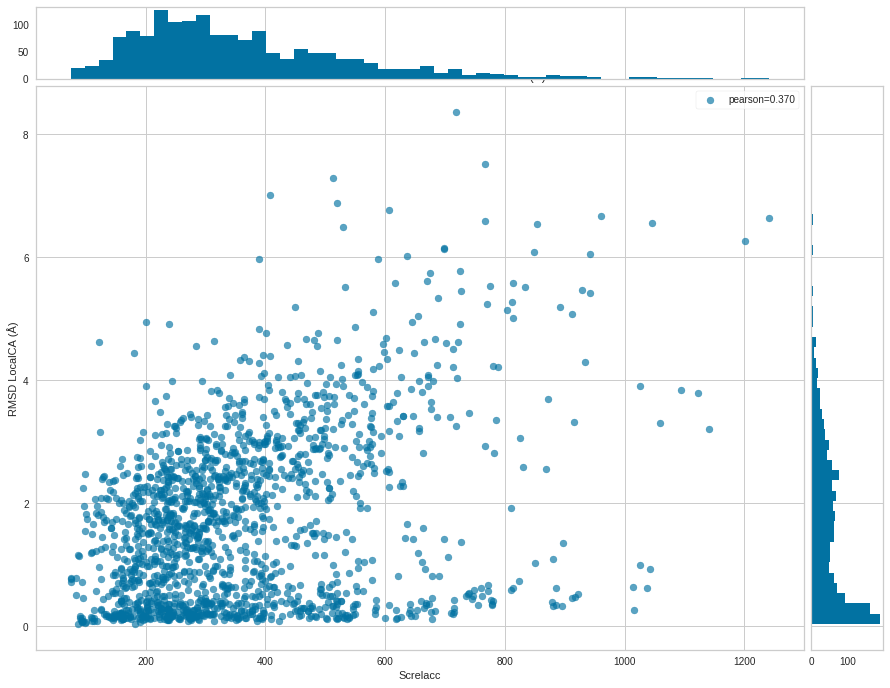

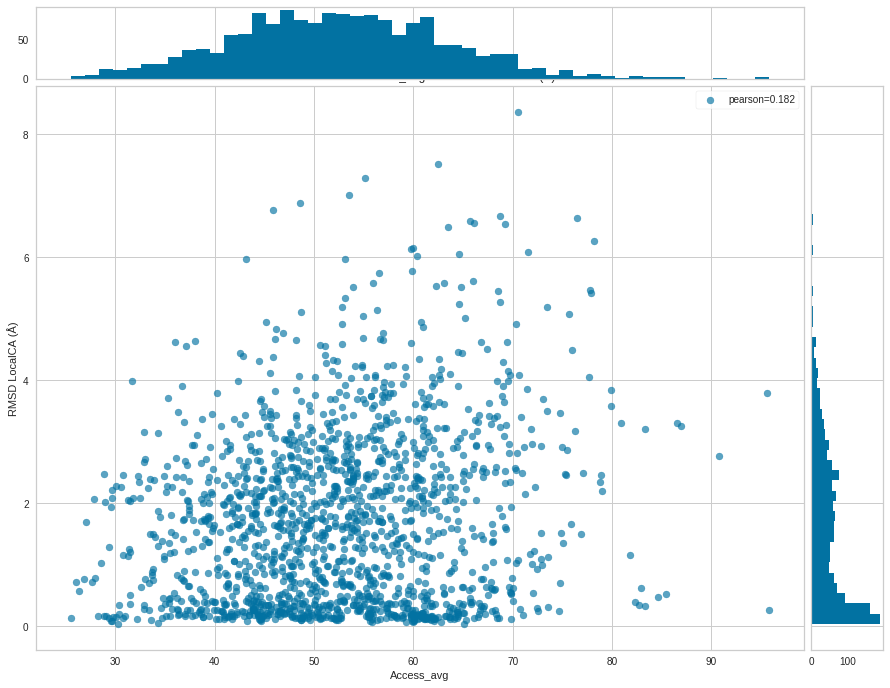

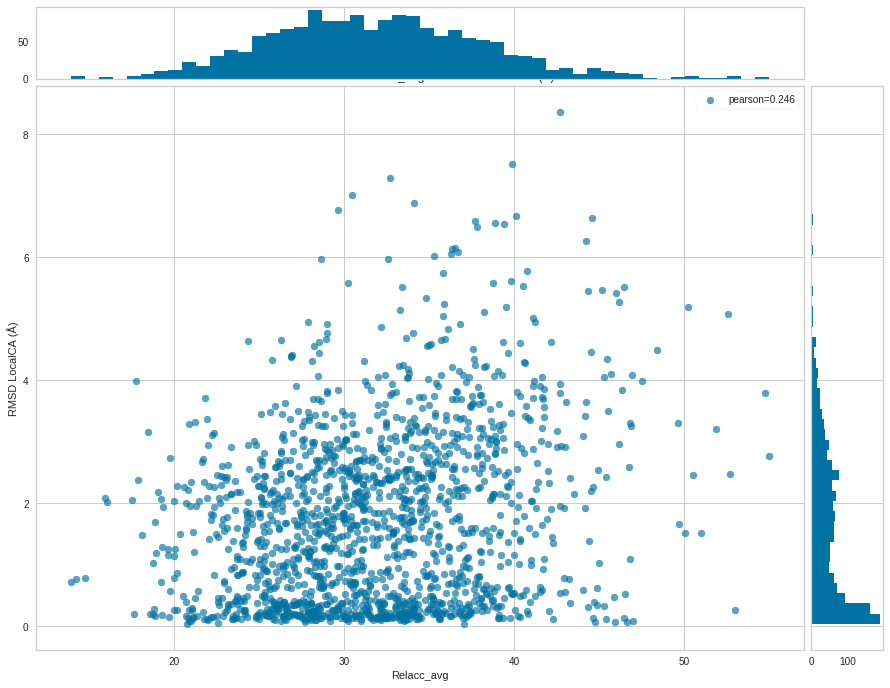

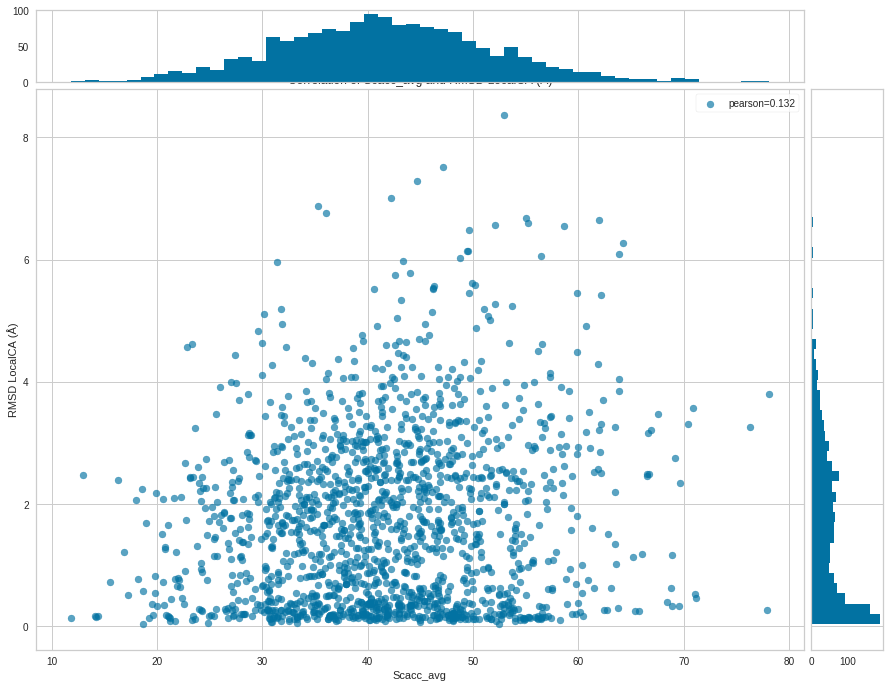

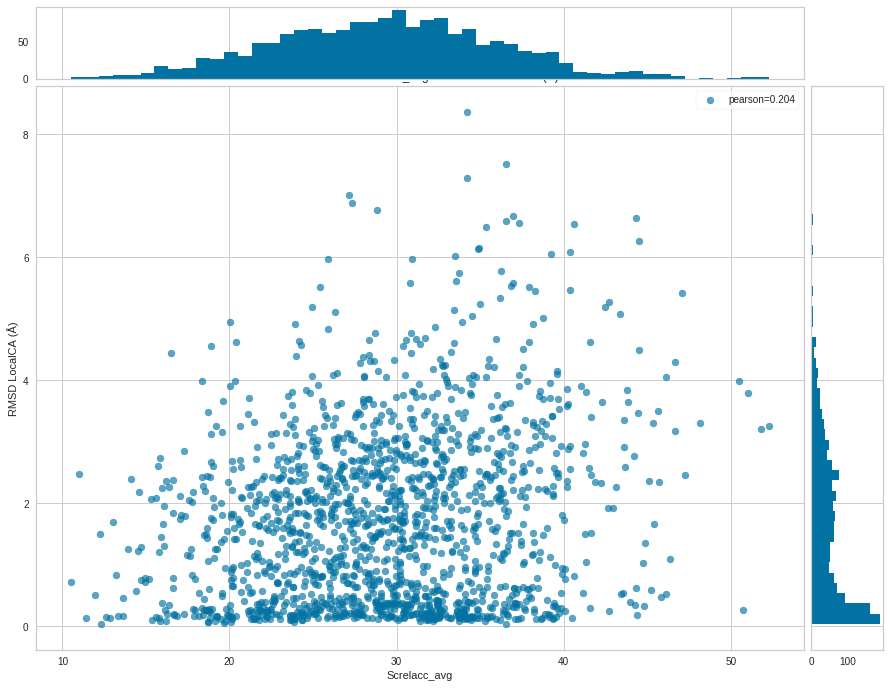

In [11]:
import os
abYmod_logs=os.path.join(CONF["abymod_logs"])
myfunctions=os.path.join(CONF["qualiloop_scripts"],"myfunctions.py")
feature_dir=os.path.join(CONF["feature_dir"])
feature_csv=os.path.join(feature_dir,"full_features.csv")
import sys

viz_script=os.path.join(CONF["qualiloop_scripts"],"grapher.py")
from grapher import plot_graph
plot_graph(feature_csv,"Access")
plot_graph(feature_csv,"Relacc")
plot_graph(feature_csv,"Scacc")
plot_graph(feature_csv,"Screlacc")
plot_graph(feature_csv,"Access_avg")
plot_graph(feature_csv,"Relacc_avg")
plot_graph(feature_csv,"Scacc_avg")
plot_graph(feature_csv,"Screlacc_avg")

#### 3.5. Happiness

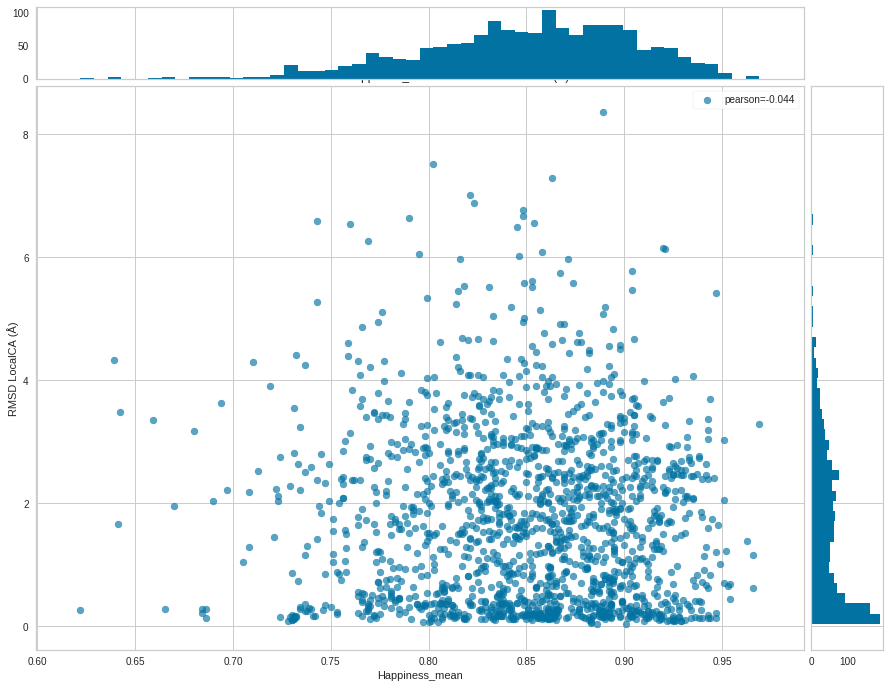

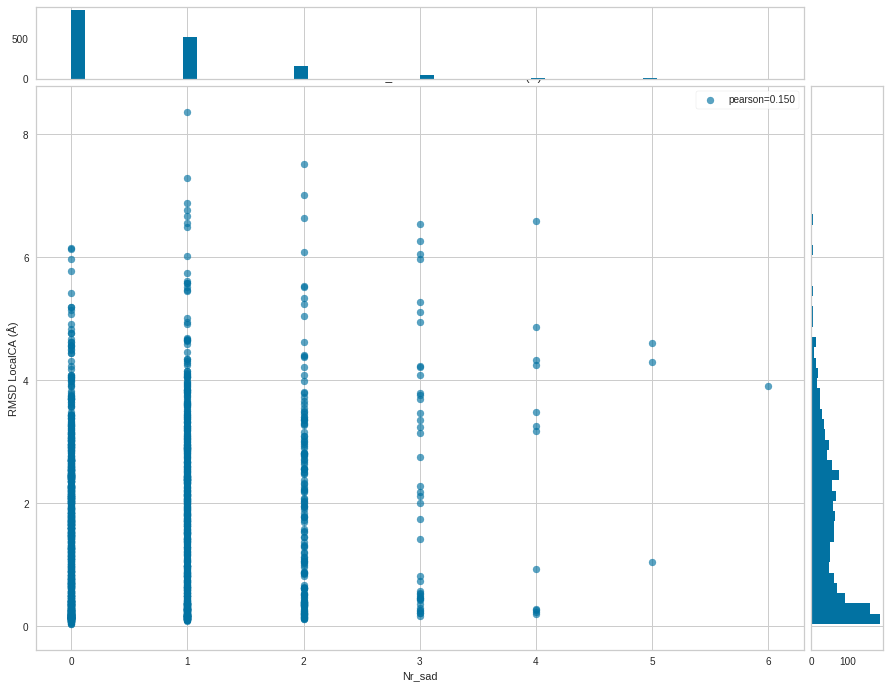

In [12]:
import os
abYmod_logs=os.path.join(CONF["abymod_logs"])
myfunctions=os.path.join(CONF["qualiloop_scripts"],"myfunctions.py")
feature_dir=os.path.join(CONF["feature_dir"])
feature_csv=os.path.join(feature_dir,"full_features.csv")
import sys

viz_script=os.path.join(CONF["qualiloop_scripts"],"grapher.py")
from grapher import plot_graph
plot_graph(feature_csv,"Happiness_mean")
plot_graph(feature_csv,"Nr_sad")

#### 3.6. Protrusion

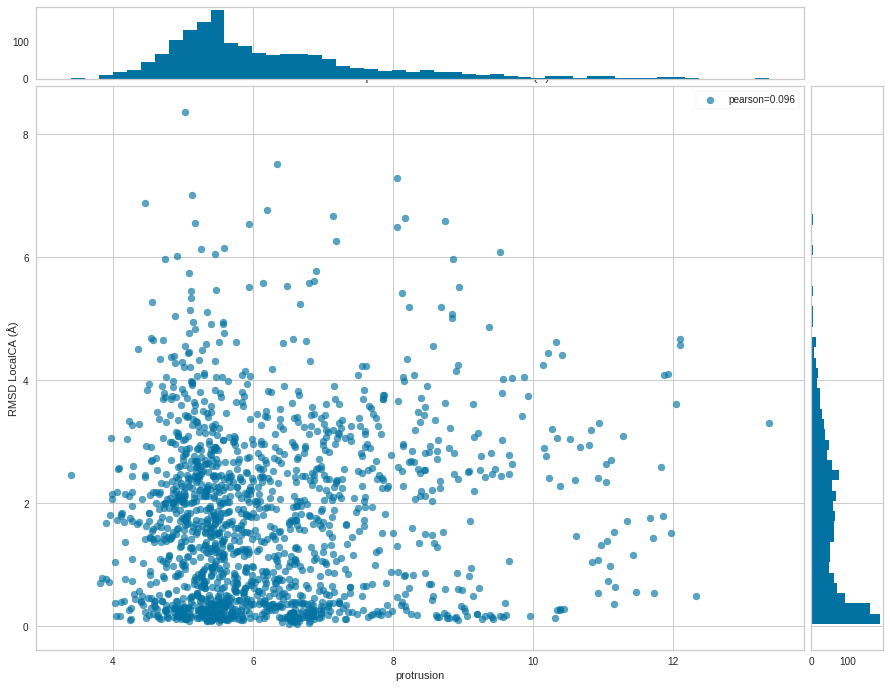

In [7]:
import os
abYmod_logs=os.path.join(CONF["abymod_logs"])
myfunctions=os.path.join(CONF["qualiloop_scripts"],"myfunctions.py")
feature_dir=os.path.join(CONF["feature_dir"])
feature_csv=os.path.join(feature_dir,"full_features.csv")
import sys

viz_script=os.path.join(CONF["qualiloop_scripts"],"grapher.py")
from grapher import plot_graph
plot_graph(feature_csv,"protrusion")

The tip residue (i.e one-letter AA code ) is also included in the dataset. This feature is are non-numerical and must be encoded afterwards. The tip position (i.e residue number) is also included in the dataset. The feature is not numerical either, given that it is categorical in nature (in addition to inserted resiude being numbered as 100A,100B,etc.) 

#### 3.7. Simlength

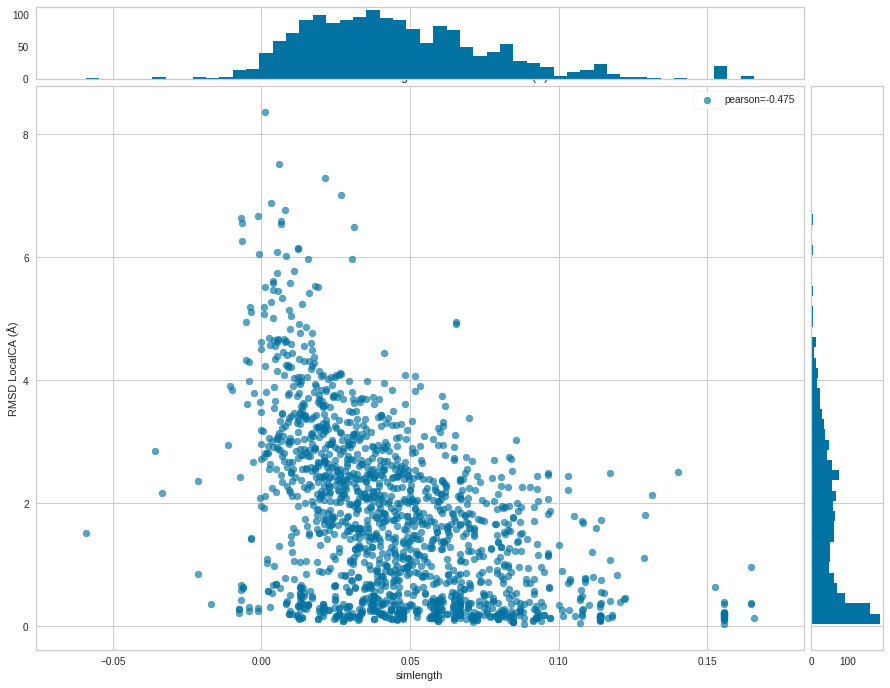

In [14]:
import os
abYmod_logs=os.path.join(CONF["abymod_logs"])
myfunctions=os.path.join(CONF["qualiloop_scripts"],"myfunctions.py")
feature_dir=os.path.join(CONF["feature_dir"])
feature_csv=os.path.join(feature_dir,"full_features.csv")
import sys

viz_script=os.path.join(CONF["qualiloop_scripts"],"grapher.py")
from grapher import plot_graph
plot_graph(feature_csv,"simlength")

#### 3.10. Contacts

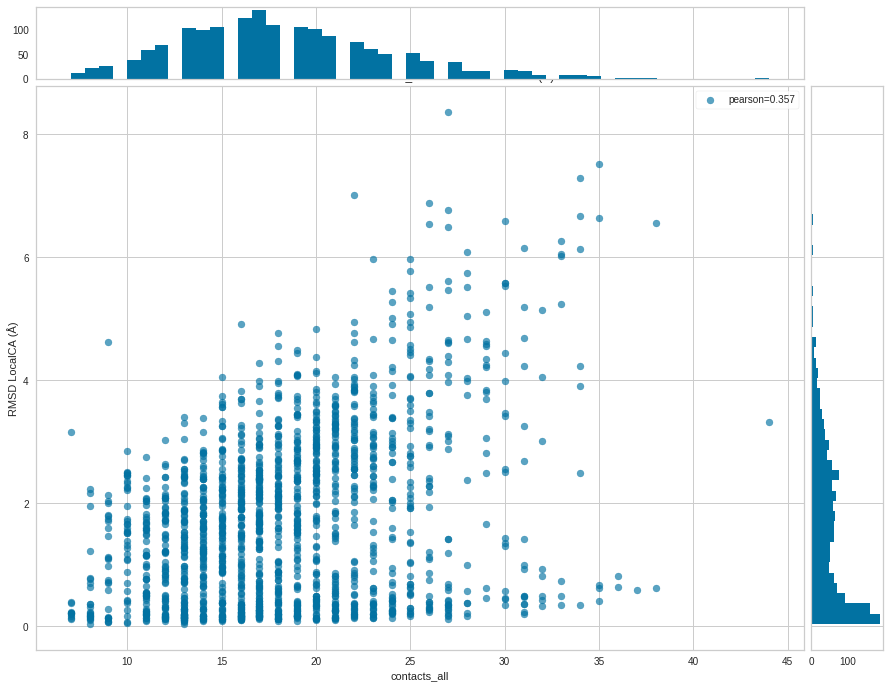

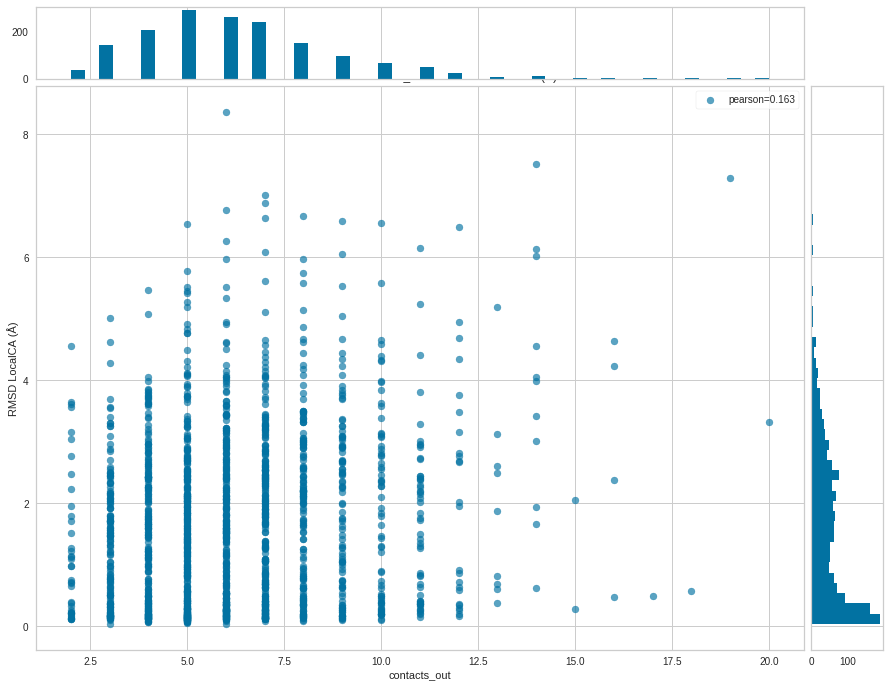

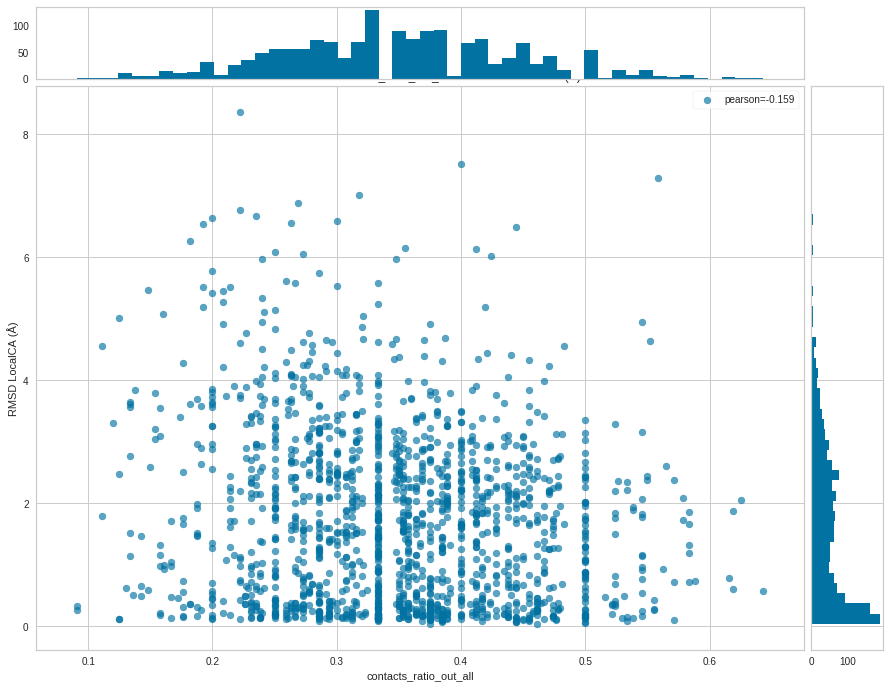

In [5]:
import os
abYmod_logs=os.path.join(CONF["abymod_logs"])
myfunctions=os.path.join(CONF["qualiloop_scripts"],"myfunctions.py")
feature_dir=os.path.join(CONF["feature_dir"])
feature_csv=os.path.join(feature_dir,"full_features.csv")
import sys

viz_script=os.path.join(CONF["qualiloop_scripts"],"grapher.py")
from grapher import plot_graph
plot_graph(feature_csv,"contacts_all")
plot_graph(feature_csv,"contacts_out")
plot_graph(feature_csv,"contacts_ratio_out_all")

#### 3.12. Blosum-Pairwise-Difference

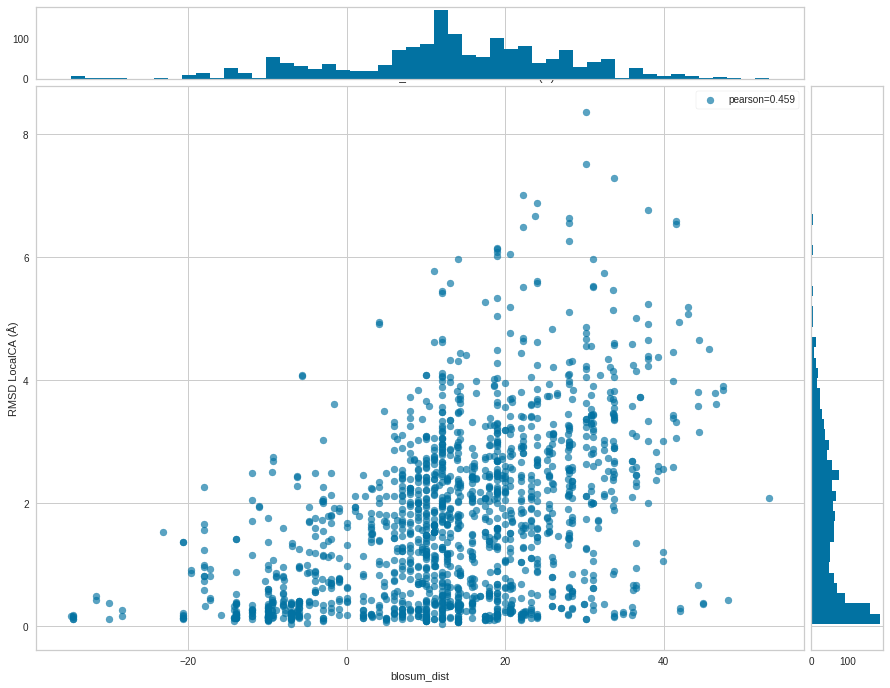

In [15]:
import os
abYmod_logs=os.path.join(CONF["abymod_logs"])
myfunctions=os.path.join(CONF["qualiloop_scripts"],"myfunctions.py")
feature_dir=os.path.join(CONF["feature_dir"])
feature_csv=os.path.join(feature_dir,"full_features.csv")
import sys

viz_script=os.path.join(CONF["qualiloop_scripts"],"grapher.py")
from grapher import plot_graph
plot_graph(feature_csv,"blosum_dist")

#### 3.14. Bulged

### 4. Target Encoding

<i>11.12.20</i>

The numerical target local_Ca RMSD (as well as global_Ca,local_all atoms, global all atoms) must be nominally encoded. This is so that classification methods can be applied. 

In [19]:
import os
import pandas as pd
import numpy as np
actual_PDBs=os.path.join(CONF["actual_PDBs_NR"])
import sys
abYmod_structures=os.path.join(CONF["abymod_structures"])
actual_PDBs_NR=os.path.join(CONF["actual_PDBs_NR"])
modelmaker=os.path.join(CONF["qualiloop_scripts"],"modelmaker.py")
sys.path.append(modelmaker)

feature_dir=os.path.join(CONF["feature_dir"])
feature_csv_save=os.path.join(feature_dir,"full_features_noms.csv")

from modelmaker import make_df_nombin
full_dataset=pd.DataFrame()


threshold_list=[1,2,3,4,5,6,7,8]
threshup=[2,4,6,8,100]
threshlow=[0,2,4,6,100]
RMSD_mode=["local_CA","local_AA", "global_CA", "global_AA"]

for mode in RMSD_mode:
    for file in os.listdir(abYmod_structures):
        ID=file.replace(".pdb", "")
        print(ID)
        file=os.path.join(abYmod_structures,file)
        actual_file=os.path.join(actual_PDBs_NR,ID+".pdb")
        row=make_df_nombin(mode, file, actual_file,threshold_list, threshup, threshlow)
        full_dataset=pd.concat([full_dataset, pd.DataFrame(row)], ignore_index=True)
    full_dataset.to_csv(feature_csv_save)


3V6O_1.model
df_all_bins Empty DataFrame
Columns: []
Index: []
[0, 2, 4] [2, 4, 6]
RMSD_num_df Empty DataFrame
Columns: []
Index: [] Empty DataFrame
Columns: []
Index: []
6C5H_1.model
df_all_bins Empty DataFrame
Columns: []
Index: []
[0, 2, 4] [2, 4, 6]
RMSD_num_df Empty DataFrame
Columns: []
Index: [] Empty DataFrame
Columns: []
Index: []
3GHE_1.model
df_all_bins Empty DataFrame
Columns: []
Index: []
[0, 2, 4] [2, 4, 6]
RMSD_num_df Empty DataFrame
Columns: []
Index: [] Empty DataFrame
Columns: []
Index: []
5EOQ_1.model
df_all_bins Empty DataFrame
Columns: []
Index: []
[0, 2, 4] [2, 4, 6]
RMSD_num_df Empty DataFrame
Columns: []
Index: [] Empty DataFrame
Columns: []
Index: []
4DTG_1.model
df_all_bins Empty DataFrame
Columns: []
Index: []
[0, 2, 4] [2, 4, 6]
RMSD_num_df Empty DataFrame
Columns: []
Index: [] Empty DataFrame
Columns: []
Index: []
5H2B_1.model


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/lilian/sync_project/WWW/CDRH3loop/CDRH3loop/qualiloop/save_RMS_lib.py", line 70, in RMSD_binary
    RMSD_num_col=RMSD_num_df[RMSD_mode].tolist()
TypeError: 'NoneType' object is not subscriptable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/lilian/sync_project/WWW/CDRH3loop/CDRH3loop/qualiloop/save_RMS_lib.py", line 59, in run_num
    RMSD_num_df=pass_Profit_commands("/serv/www/html_lilian/libs/qualiloop/RMS_calc", file, actual_file)
  File "/home/lilian/sync_project/WWW/CDRH3loop/CDRH3loop/qualiloop/save_RMS_lib.py", line 17, in pass_Profit_commands
    profit_out=subprocess.check_output(command, shell=True)
  File "/usr/lib/python3.8/subprocess.py", line 411, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
  File "/usr/lib/python3.8/subprocess.py", line 512, in run
    raise CalledProcessError(retcode, process.args,
subprocess.

TypeError: object of type 'NoneType' has no len()

The produced dataset has many binary columns. For each RMSD mode there is a set of bin columns, one for each threshold specified. Additionally, there is one nominal column per RMSD mode. These columns assign a categorical value according to the class in which the abYmod structure falls. The thresholds for these nominal classes are specified as threshlow and threshup above. All of these processes occur automatically when using modelmaker. Individual thresholds need not be specified and this run is merely presented to illustrate the working. 

In [18]:
import os
feature_dir=os.path.join(CONF["feature_dir"])
feature_csv=os.path.join(feature_dir,"full_features_nom.csv")
f=pd.read_csv(feature_csv)
print(f.head())

   identity  similarity            seq  length  simlength  total_charge  \
0     0.846       0.867  RAHNVVLGDWFAY      13   0.066692           0.5   
1     0.462       0.415  PYPNDGMSWYFDL      13   0.031923          -2.0   
2     0.500       0.389         GQGRPY       6   0.064833           1.0   
3     0.900       0.917     GTSGYDYFDY      10   0.091700          -2.0   
4     0.556       0.380      NYGSDSLDY       9   0.042222          -2.0   

   nr_charged  Happiness_mean  Nr_sad tip_pos  ... global_AA_bin7.0  \
0           3           0.769     2.0      99  ...              0.0   
1           2           0.905     0.0      98  ...              1.0   
2           1           0.852     1.0      98  ...              0.0   
3           2           0.892     0.0     101  ...              0.0   
4           2           0.849     0.0      98  ...              0.0   

   global_CA_bin7.0 local_AA_bin8.0  local_CA_bin8.0  global_AA_bin8.0  \
0               0.0             0.0             

#### 4.2 Weka Experimentation with Classifiers

<i>20.12.20</i>
    
    
Again, Weka is used to explore the newly generated dataset. It becomes very clear that the number of classes and how these are 'placed' makes a great difference for the classifier performance. 

Trends: 
- The more classes, the lower MCC score is.
- The larger the range they span the lower the MCC score to an extent. i.e. if the classes are above e.g 8Angstöms, there is too few data for accurate prediction
- The feature selection makes a great difference (explored later)
- very different results for training and testing set are common -> frequent overfitting


The best result achieved is an MCC of 0.55 with a binary classifier at 2 Angstroms using an SVM. 

Note: just for exploration, no real data gathering.



### 5.Classifier Algorithms

<i>08.01.21</i>

For each created model, the program will loop through a series of machine learning models. Each model type will be trianed and tested. The best model will be used/incorported into the final classifier. 
The used models are:

NOTE: XGB Classifier was added later. It is not incorporated into the Voting Classifier because of this. It will be included in the future. This may help to produce an even better classifier given that XGBoost always does very well. 

NOTE: Hard Voting was not included when building the final model, as the model can't produce probability predictions, which are needed. 




In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

models=[]
models.append(('LogisticRegression', LogisticRegression(solver='liblinear', multi_class='ovr')))
#models.append(('LinearDiscriminantAnalysis',LinearDiscriminantAnalysis()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('RandomForestClassifier',RandomForestClassifier(n_estimators=200)))
no_vote_models=models.copy()
models.append(('SVC', SVC(gamma='auto')))
no_vote_models.append(('SVC', SVC(gamma='auto', probability=True)))  #without defining probability=True, soft voting fails
models.append(('Voting_all_soft', VotingClassifier(estimators=no_vote_models, voting='soft', weights=[1]*len(no_vote_models), flatten_transform=True)))
models.append(('XGBoost', xgb.XGBClassifier()))
#models.append(('Voting_all_hard', VotingClassifier(estimators=no_vote_models, voting='hard'))) #has no proba prediction
print(models)

[('LogisticRegression', LogisticRegression(multi_class='ovr', solver='liblinear')), ('KNeighborsClassifier', KNeighborsClassifier()), ('DecisionTreeClassifier', DecisionTreeClassifier()), ('GaussianNB', GaussianNB()), ('RandomForestClassifier', RandomForestClassifier(n_estimators=200)), ('SVC', SVC(gamma='auto')), ('Voting_all_soft', VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(multi_class='ovr',
                                                 solver='liblinear')),
                             ('KNeighborsClassifier', KNeighborsClassifier()),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier()),
                             ('GaussianNB', GaussianNB()),
                             ('RandomForestClassifier',
                              RandomForestClassifier(n_estimators=200)),
                             ('SVC', SVC(gamma='auto', probability=True))],
                 

### 6.Hyperparameter Optimization 

<i>17.02.21</i>

Two different methods for hyperparameter optimization were developed and tested. 
First, a hybrid of random searching and grid searching, secondly a genetic algorithm.

The two methods were compared regarding how they improved the MCC of models:

In [3]:
import os
import pandas as pd
feature_dir=os.path.join(CONF["feature_dir"])
feature_csv=os.path.join(feature_dir,"hyperparam_opti.csv")
f=pd.read_csv(feature_csv, sep="    ")
print(f)

          Target Y XGB MCC Before Optimization XGB MCC After Optimization  \
0    local_CA_bin1                     0,56117                    0,53570   
1    local_CA_bin2                     0,54480                    0,60826   
2    local_CA_bin3                     0,50495                    0,62405   
3    local_CA_bin4                     0,43989                    0,68386   
4    local_CA_bin5                     0,40961                    0,57644   
5    local_CA_bin6                     0,34866                    0,69540   
6    local_AA_bin1                     0,60366                    0,49534   
7    local_AA_bin2                     0,49983                    0,51645   
8    local_AA_bin3                     0,50386                    0,56344   
9    local_AA_bin4                     0,58754                    0,57058   
10   local_AA_bin5                     0,45194                    0,55252   
11   local_AA_bin6                     0,32972                    0,58736   

<ipython-input-3-9adab1fee94c>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  f=pd.read_csv(feature_csv, sep="    ")


The results showed the two were very comparable, however the genetic algorithm outperformed the hybrid method slightly. 
The shwon results are for GA of 25 generations. The number of generations was increased to 100, to ensure optimisation was complete. Although the optimization calculations are rather time-consuming, they are an imprtant step to ensure the ML models have the correct parameters set for leanring. 

The Voting classifier takes oll of these optimized models as input. The weights of each contributing classifier is then determined by applying scipy minimize (log-loss function). 

#### 6.1 Hybrid Method 

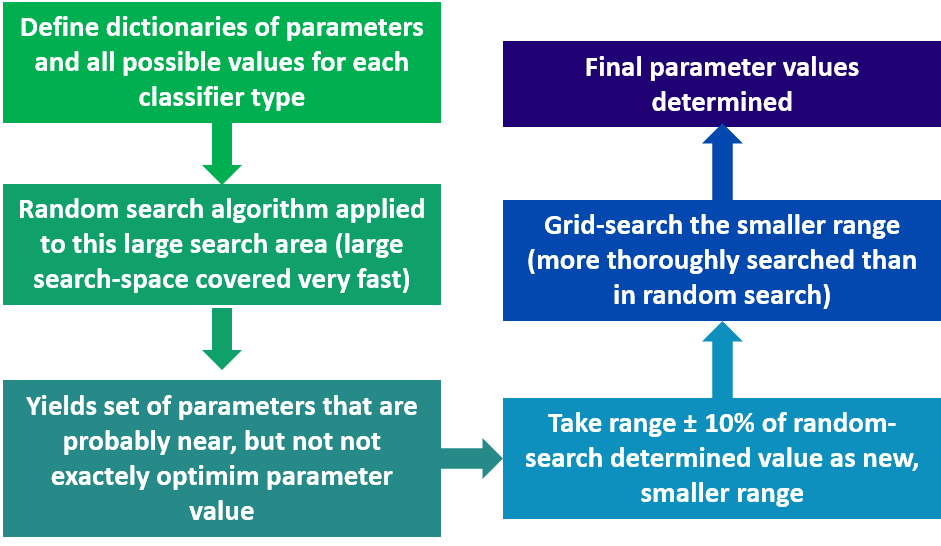

In [5]:
import os
imgpath=str(os.path.join(CONF["lab_book_pics"],"hyperparam_hybrid.png"))
display.Image(imgpath)

#### 6.2 Genetic Algorithm Method 

<i>05.03</i>
The genetic algorithm is not stopped at a specific MCC threshold, but rather runs for 100 generations. Alter this in future to save time. 

NOTE: Memory problems with implementing the genetic algorithm.
Memory was not cleared between cycles, which lead to the program being killed by the out-of-memory killer.

The initialization step and the training step were transported to separate programs from the top-layer script to solve this problem

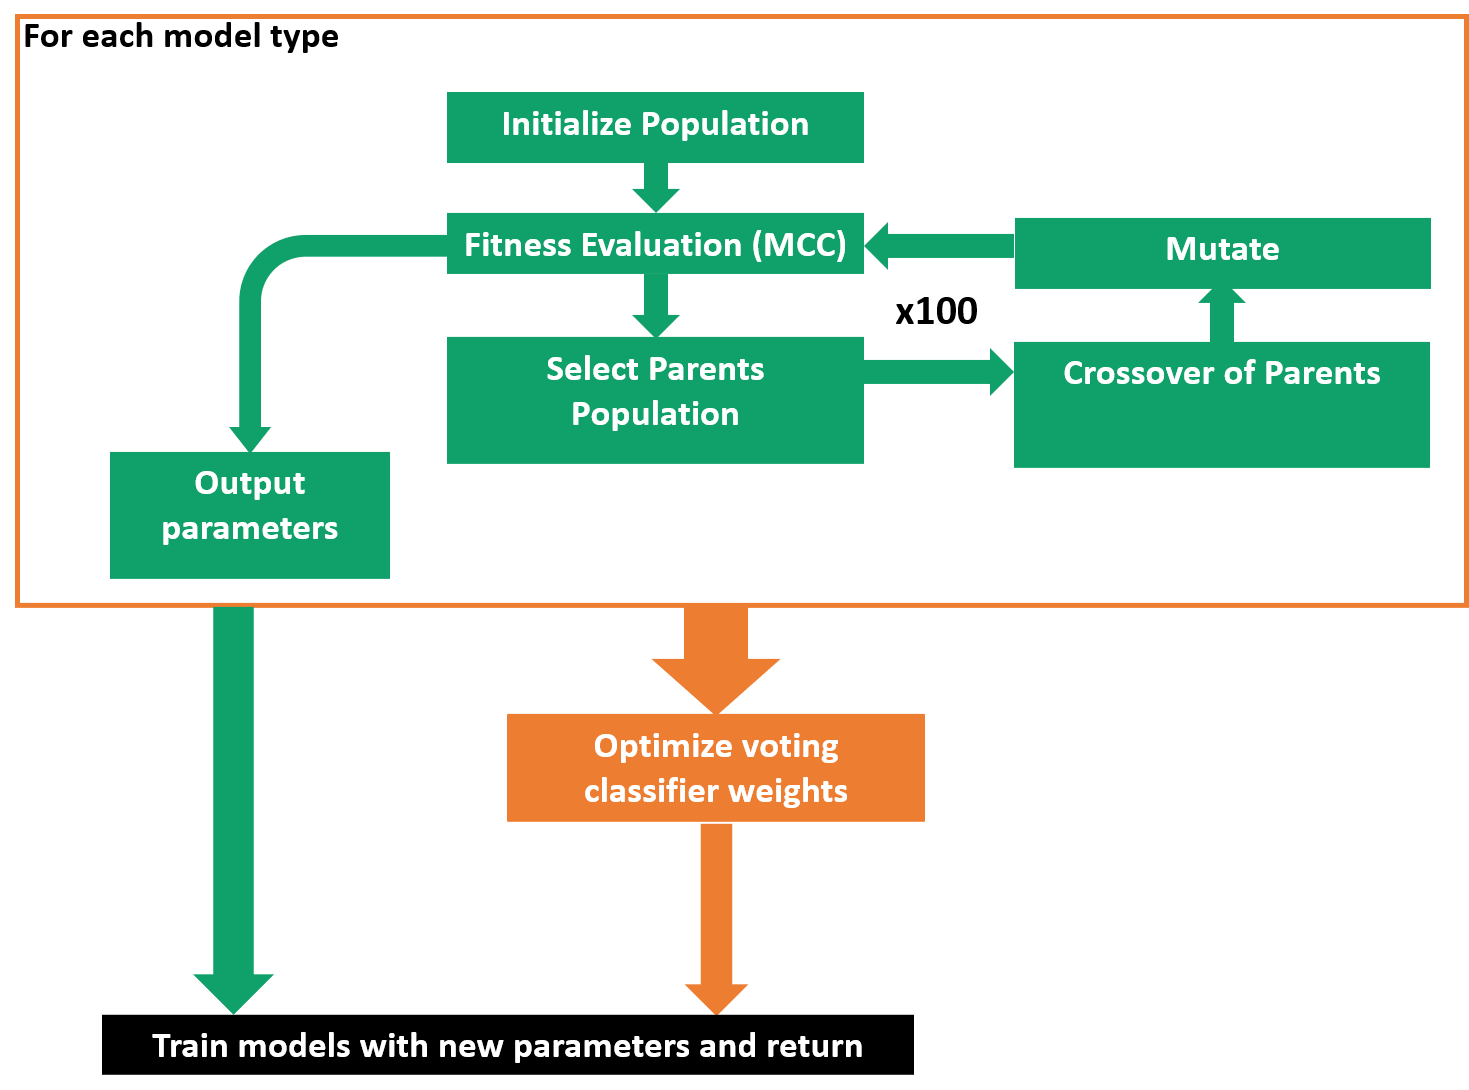

In [6]:
import os
imgpath=str(os.path.join(CONF["lab_book_pics"],"hyperparam_genetic.png"))
display.Image(imgpath)

### 7. Staggered Model Architecture 
<i>15.01.21</i>

As seen during prelimiary testing, the binary classifiers tend to to much better than all nominal classifiers. However, a nominal classifier would be prefered given it offers more information to a user. Thus an ensemble model structure is created. 


The idea of the staggered bin model is similar to a general bagging algorithm:


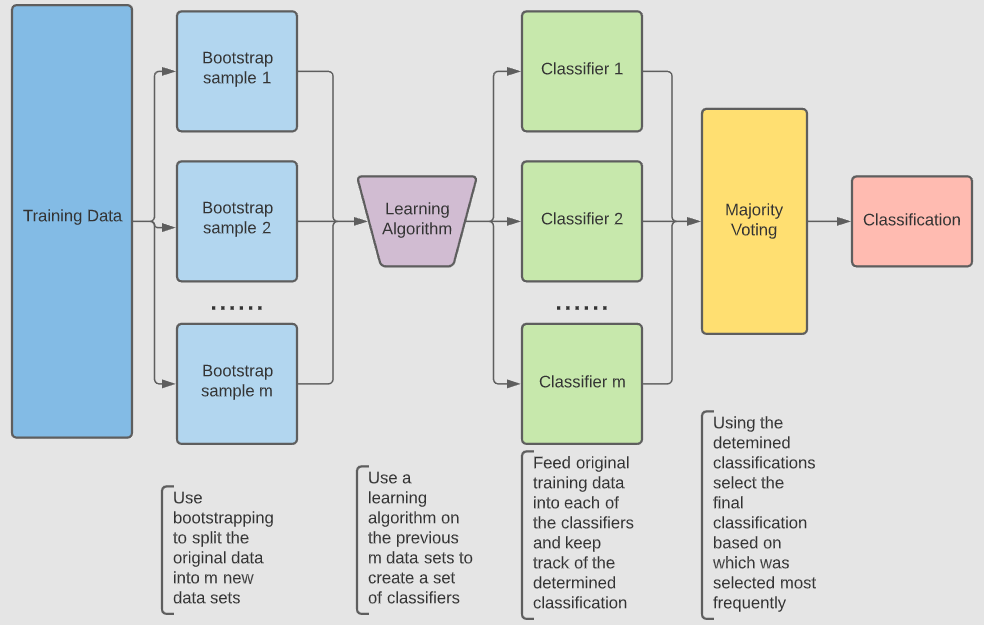

In [4]:
import os
imgpath=str(os.path.join(CONF["lab_book_pics"],"bagging.png"))
display.Image(imgpath)

source: https://en.wikipedia.org/wiki/Bootstrap_aggregating#/media/File:Bagging_for_Classification_with_descripitons.png

However,the method works slightly differently:

In a first layer, numerous models are created, one for each binary threshold. Each model is then saved as either a .pkl file or a .json file (if it is an xgb model).
For each threshold model each of the classifier types are trained and tested. The best-performing model will be saved. 

The predictions for all binary classifiers with thresholds within the range of a nominal class are then averaged. 
i.e:
((prob model is above 1)+...(prob model is above 1.9))/nr. of binary classifiers

for each nominal class. 
Effectively, this is a soft-voting procedure creating additional features for the second-layer meta-classifier. 

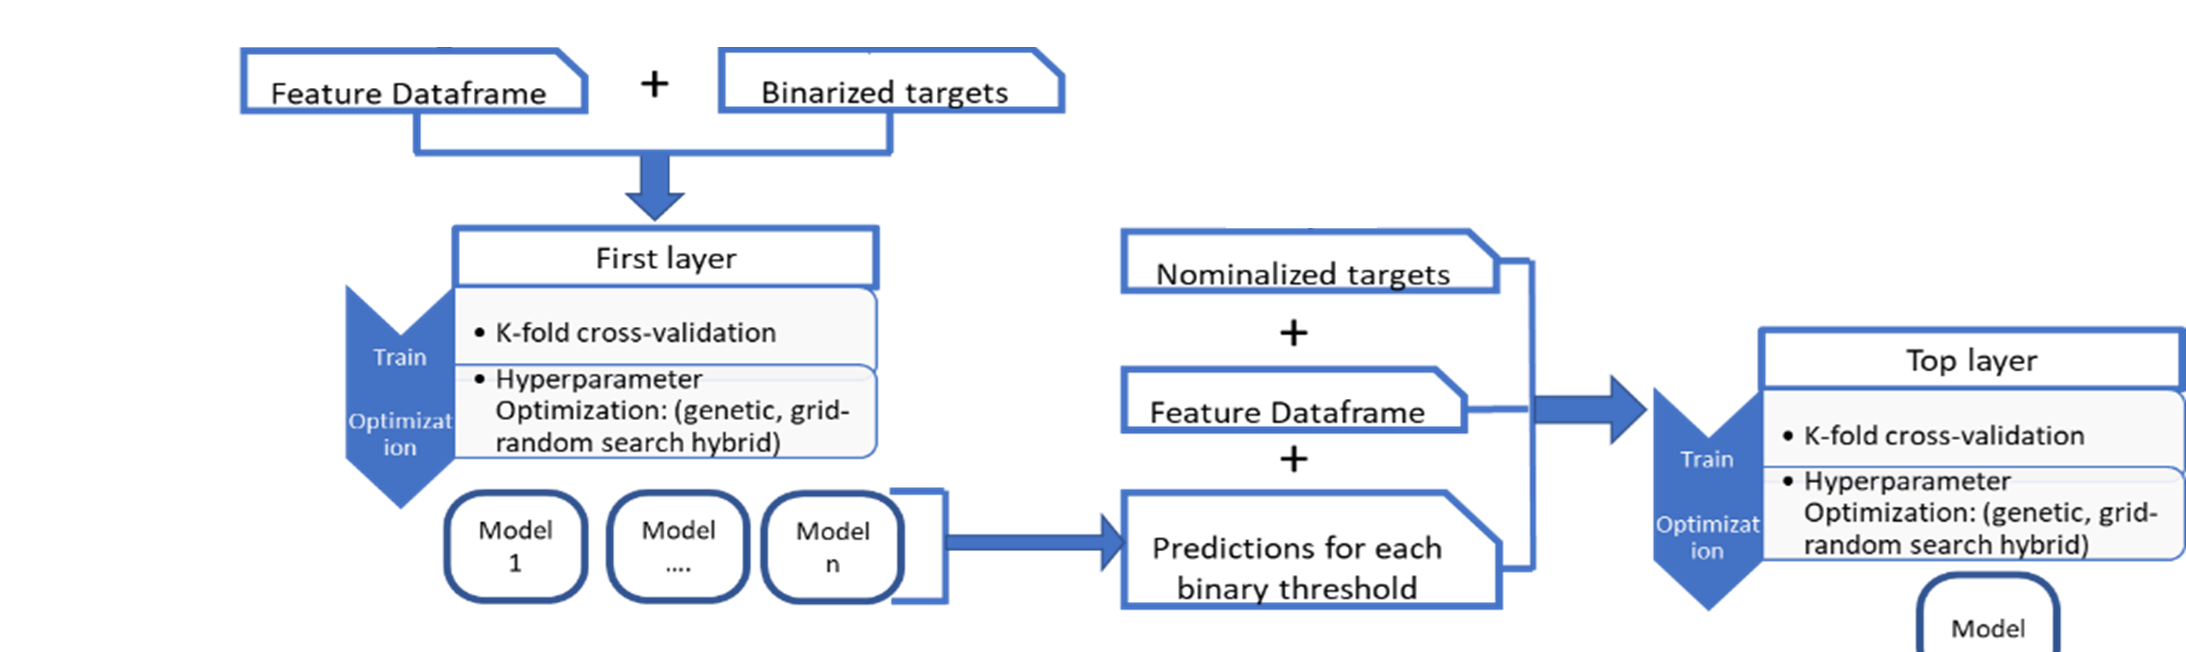

In [5]:
import os
imgpath=str(os.path.join(CONF["lab_book_pics"],"staggering.png"))
display.Image(imgpath)

## Target Categorization and setting binary thresholds

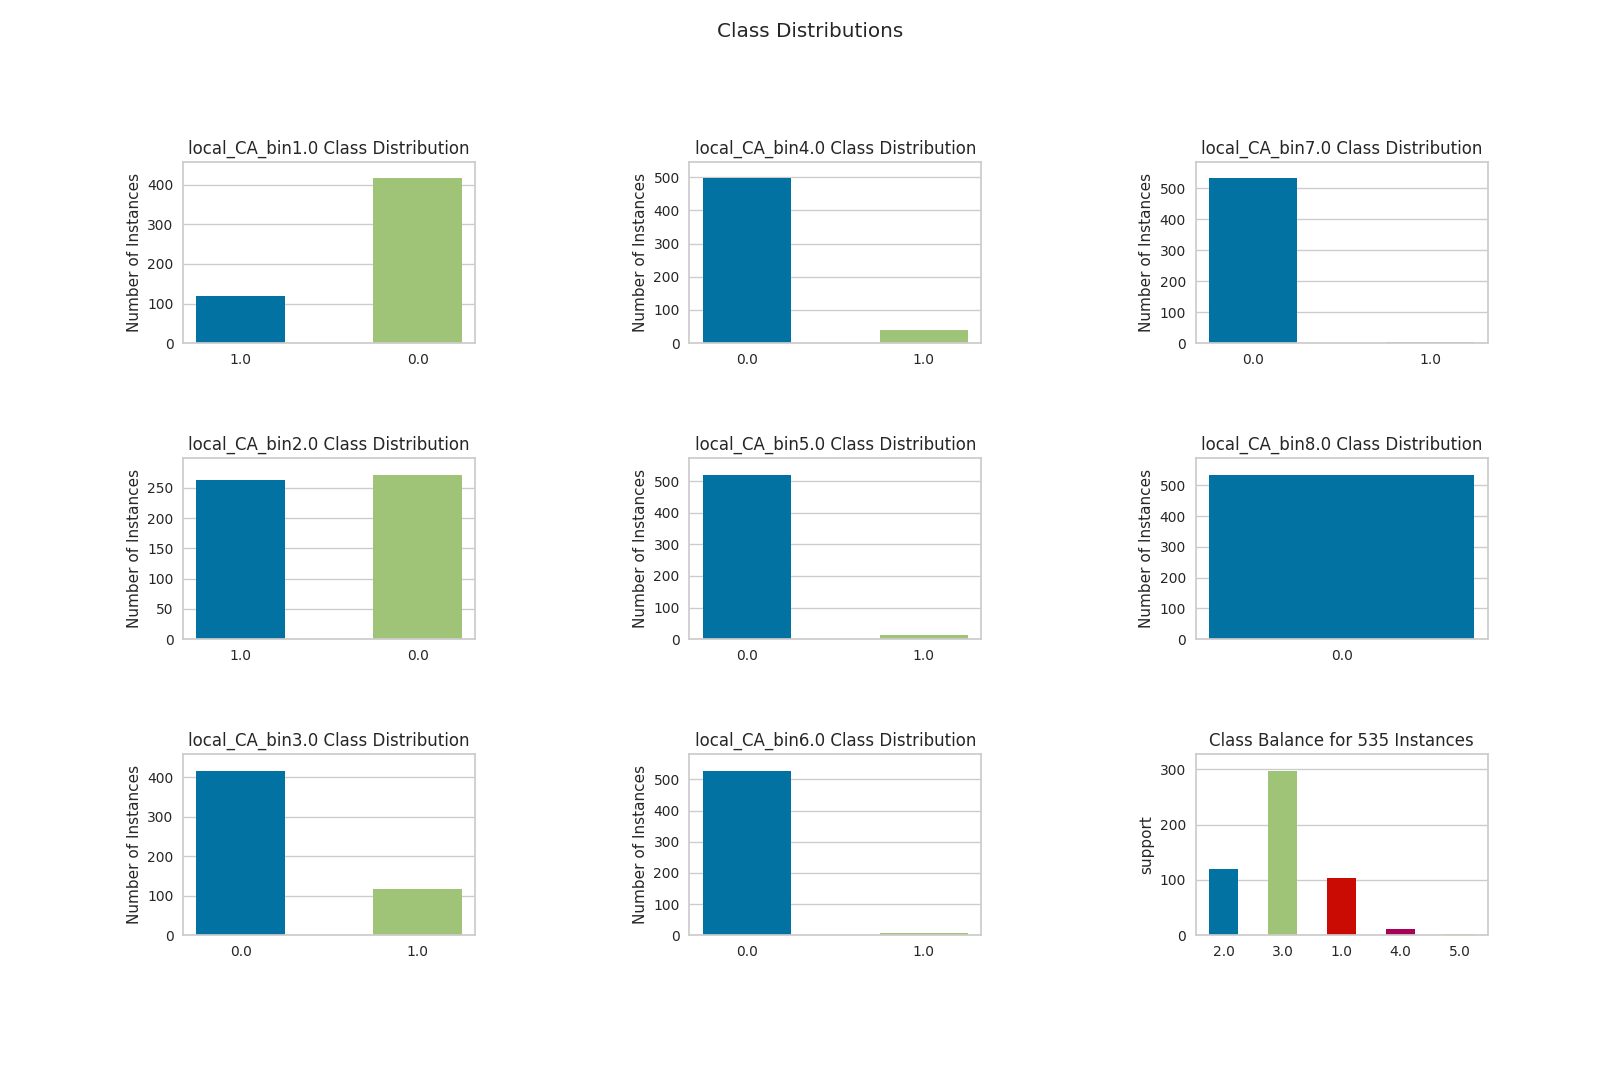

In [20]:
imgpath=str(os.path.join(CONF["lab_book_pics"],"local_CA_bins_distributions_1.png"))
display.Image(imgpath)

This collection of graphs illustrate how the samples are divided among the different classes (nominal and binaryy). 

It is of special note that binary class 8.0 does not contain any samples above and RMSD of 8Angström. Therefore, this classifier will not have sufficient data to learn from. This binary threshold should thus be removed in the future. Furthermore, very few samples above the thresholds 5.0,6.0 and 7.0 exists and it is probable that the classfifiers will make worse predictions. 

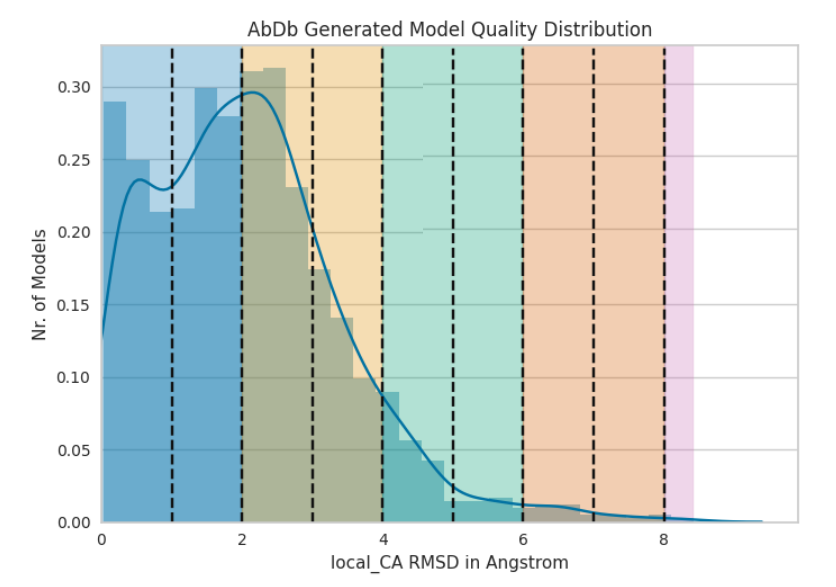

In [23]:
imgpath=str(os.path.join(CONF["lab_book_pics"],"local_CA_noms_distribution_1.png"))
display.Image(imgpath)

Shown above is the distribution of local_CA RMSD. The dashed lines indicate the binary thresholds set. The coloured panels whow where the nominal classes lie. note that the class for the pink panels effectively extends until 100(which is much higher than any RMSD value in the dataset).

One can clearl see that the number of samples are not fairly divided into each nominal class. The first class has the most samples, while the last class has barely any.

THis will be adressed in the future. Balanced classes (i.e. each nominal class has same amout of samples) will be set up and the effect of this on the classifier will be tested. 

#### 4.4 Balanced Classes

<i>18.01.21</i>


Balanced binary classes have thresholds not set by the program explicitly, but they are infered from the dataset and the number of classes to be made. 

In modelmaker an additional option is included, which will create balanced classes. As iput the number of binary classses, and an overall RMSD range is taken. 

In [10]:
import os
import pandas as pd
import numpy as np
actual_PDBs=os.path.join(CONF["actual_PDBs_NR"])
import sys
abYmod_structures=os.path.join(CONF["abymod_structures"])
actual_PDBs_NR=os.path.join(CONF["actual_PDBs_NR"])
abYmod_logs=os.path.join(CONF["abymod_logs"])
modelmaker=os.path.join(CONF["qualiloop_scripts"],"modelmaker.py")
sys.path.append(modelmaker)

feature_dir=os.path.join(CONF["feature_dir"])
feature_save=os.path.join(feature_dir,"balanced_bins_full_dataset")

from modelmaker import get_full_dataset_df
full_dataset=pd.DataFrame()

full_dataset_df, bin_thresholds, val_dic=get_full_dataset_df(abYmod_structures, abYmod_logs,actual_PDBs_NR,threshold_bins_staggered=[0], 
         step_size_nom_staggered=[2,2,2,2],save_to_path=os.path.join(feature_save+".csv"),
         nr_of_balanced_bins=10, balanced=True)

full_dataset_df.to_csv(feature_csv_save)


RMSD_num_df



KeyboardInterrupt



However, the issue with this balanced-bin approach is that the RMSD distribution is so skewed. The majority of instances are located within a small range compared to the total range.

#### 4.5 Staggered Bins

The ensemble-structure of many binary classifiers that feed into a top-layer meta-classifier is used in to test runs below. 

The parameters taken are as follows:
threshold_bins_staggered is a list of four lists. each of the fozr lists corresponds to either local_AA,local_CA, global_AA, or global_CA.
The first value in each sub-list is the min value for the binary classifiers. If it is 1, the first binary threshold will be 1.0. The second is the maximum. the third value is the number of binary bins are to be created.

step_size_nom_staggered is a list of four values, again each corresponding to local_AA,local_CA, global_AA, or global_CA. The value is the size of nominal classes (which start from the min Angstrom value given). 

## COMPLETE TEST RUNS 

All aspects of the project, including abYmod modeling, feature calculation, RMSD calculation, data preprocessing, feature encoding, feature selection, ML model training, ML hyperparamter optimization and visualisation is automated in a single top-layer program. This way, all different options can be explored in one, and the experiments easily run. 

The created raw dataset is saved, as well as after scaing and encoding. The features will be visualized regarding their correlation with the RMSD. Furthermore, the models' leanring is illustrated by learning cureves, Precision-recall curves and ROC/AUC curves.

ML models will be build using only the rudimentary features length, similarity and identity. This is to see how the model benefits from the added features and the more complex model structure. 

Then, differnet feature selection methods are applied and for each selected feature subset an ensemble classifier is created and evaluated using a separate validation set. THe results are outputted as .csv files as well as the graphs descibed earlier. 

For each complete run the mode of target categorisation can be selected. Possible options are uniform bins, balanced bins, or staggered bins. 
(NOTE: there are also some options for taking already-made datasets or RMSD-files. However, these are just for time-saving purposes.)



In [ ]:
import os
import pandas as pd
import numpy as np
import sys
save_data_dir=os.path.join(CONF["save_data_dir"])
actual_PDBs=os.path.join(CONF["actual_PDBs_NR"])
abYmod_structures=os.path.join(CONF["abymod_structures"])
actual_PDBs_NR=os.path.join(CONF["actual_PDBs_NR"])
abYmod_logs=os.path.join(CONF["abymod_logs"])
model_experimenter=os.path.join(CONF["qualiloop_scripts"],"model_experimenter.py")
sys.path.append(model_experimenter)


In [ ]:
manual_sele=[['tip_pos', 'protrusion', 'length', 'total_charge', 'nr_charged', 'identity', 'similarity','Hydropathy','Hydropathy_diff'], 
   ['blosum_dist','tip_pos', 'protrusion', 'length', 'total_charge', 'nr_charged', 'identity', 'similarity','Hydropathy','Hydropathy_diff', "contacts_all"], 
   ['blosum_dist', 'contacts_all', 'Screlacc', 'Access', 'simlength', 'Scacc',  'identity', 'Relacc', 'tip_pos', 'protrusion', 'length', 'total_charge', 'nr_charged', 'identity', 'similarity','Hydropathy','Hydropathy_diff'], 
   ['blosum_dist','tip_pos', 'protrusion', 'length', 'total_charge', 'nr_charged', 'identity', 'similarity','Hydropathy','Hydropathy_diff', 'simlength', "PCAtip_res_blosum_621_blosum_62_","PCAtip_res_blosum_622_blosum_62_","PCAtip_res_blosum_623_blosum_62_"],
   ['blosum_dist','tip_pos', 'protrusion', 'length', 'total_charge', 'nr_charged', 'identity', 'similarity','Hydropathy','Hydropathy_diff', 'simlength', "PCAtip_res_NLF1_NLF_col","PCAtip_res_NLF2_NLF_col","PCAtip_res_NLF3_NLF_col"],
   ['blosum_dist','tip_pos', 'protrusion', 'length', 'total_charge', 'nr_charged', 'identity', 'similarity','Hydropathy','Hydropathy_diff', 'simlength', "res_charge_physiochem_4d_","res_sc_nr_physiochem_4d_","res_compactness_physiochem_4d_"]]

manual_sele is a list of differnet manually selected feature sets. These will be also iterated through, in addition  to using the various feature selection methods incorporated into the program. 

In [ ]:
save_prefix="staggered_0.1_5_1_2"
stagger_params_all=[[0.1,6,1.5,2],[0.1,5,1,2],[0.1,9,1,2],[0.1,9,1,2]] #[staggering_value, max_angstrom, first_layer_size, second_layer_size]
run_dir=os.path.join(save_data_dir, save_prefix)
if not os.path.isdir(run_dir):
  os.makedirs(run_dir)
full_experimentation(model_dir, log_dir, actual_dir, threshold_bins_staggered,step_size_nom_staggered,nr_of_balanced_bins, staggered=True,stagger_params_all=stagger_params_all,
                    full_dataset_path=None, manual_sele=manual_sele,save_prefix=save_prefix, run_dir=run_dir)

In [ ]:
save_prefix="staggered_0.2_5_1.5_2"
stagger_params_all=[[0.2,6,1.5,2],[0.2,5,1.5,2],[0.2,9,1.5,2],[0.2,9,1.5,2]] #[staggering_value, max_angstrom, first_layer_size, second_layer_size]
run_dir=os.path.join(save_data_dir, save_prefix)
if not os.path.isdir(run_dir):
  os.makedirs(run_dir)
full_experimentation(model_dir, log_dir, actual_dir, threshold_bins_staggered,step_size_nom_staggered,nr_of_balanced_bins, staggered=True,stagger_params_all=stagger_params_all,
                    full_dataset_path=None, manual_sele=manual_sele,save_prefix=save_prefix, run_dir=run_dir)

In [ ]:
full_dataset_path=None
   threshold_bins_staggered=[[1,7,8], [1,8,6],[2,10,8],[1,10,8]] #"local_AA", "local_CA", "global_AA", "global_CA"
   step_size_nom_staggered=[2,2,2,2]
   nr_of_balanced_bins=10
   save_prefix="186_2_uniform"
   run_dir=os.path.join(save_data_dir, save_prefix)
   if not os.path.isdir(run_dir):
      os.makedirs(run_dir)
   full_experimentation(model_dir, log_dir, actual_dir, threshold_bins_staggered,step_size_nom_staggered,nr_of_balanced_bins, balanced=False,
                        full_dataset_path=full_dataset_path, manual_sele=manual_sele, save_prefix=save_prefix, run_dir=run_dir)

In [ ]:
full_dataset_path=None
threshold_bins_staggered=[[1,7,9], [1,8,12],[2,10,9],[1,10,9]] #"local_AA", "local_CA", "global_AA", "global_CA"
step_size_nom_staggered=[3,3,3,3]
nr_of_balanced_bins=10
save_prefix="1812_3_uniform"

run_dir=os.path.join(save_data_dir, save_prefix)
if not os.path.isdir(run_dir):
  os.makedirs(run_dir)
full_experimentation(model_dir, log_dir, actual_dir, threshold_bins_staggered,step_size_nom_staggered,nr_of_balanced_bins, balanced=False,
                    full_dataset_path=full_dataset_path, save_prefix=save_prefix, run_dir=run_dir)


### Sequence Logo 

<i>12.04.21</i>

In order to explore any sequence patterns within the CDR-H3 loop, which could lead to the inclusion of additional helpful features in the future, a sequence logo is created. 

The data on amino acid occurence at each position within the CDRH3 loop is taken from abYsis.http://www.abysis.org/abysis/

In [8]:
import os
import pandas as pd
import numpy as np
import sys
feature_dir=os.path.join(CONF["feature_dir"])
seq_logo_maker=os.path.join(CONF["qualiloop_scripts"],"seq_logo_maker.py")
sys.path.append(seq_logo_maker)
from seq_logo_maker import make_logo
make_logo(feature_dir)


['A', '800', '1.057\n']
['C', '344', '0.455\n']
['D', '711', '0.940\n']
['E', '58', '0.077\n']
['F', '2227', '2.943\n']
['G', '187', '0.247\n']
['H', '2189', '2.893\n']
['I', '4754', '6.283\n']
['K', '88', '0.116\n']
['L', '4302', '5.686\n']
['M', '175', '0.231\n']
['N', '864', '1.142\n']
['P', '3780', '4.996\n']
['Q', '253', '0.334\n']
['R', '175', '0.231\n']
['S', '2986', '3.946\n']
['T', '419', '0.554\n']
['V', '14157', '18.710\n']
['W', '105', '0.139\n']
['Y', '37047', '48.961\n']
['-', '45', '0.059\n']
['A', '2677', '6.156\n']
['C', '872', '2.005\n']
['D', '2099', '4.827\n']
['E', '593', '1.364\n']
['F', '5935', '13.649\n']
['G', '4673', '10.746\n']
['H', '870', '2.001\n']
['I', '932', '2.143\n']
['K', '442', '1.016\n']
['L', '2112', '4.857\n']
['M', '1351', '3.107\n']
['N', '1367', '3.144\n']
['P', '1645', '3.783\n']
['Q', '346', '0.796\n']
['R', '1267', '2.914\n']
['S', '3018', '6.940\n']
['T', '1375', '3.162\n']
['V', '1373', '3.157\n']
['W', '2341', '5.384\n']
['Y', '8157', '1

['A', '160', '3.191\n']
['C', '21', '0.419\n']
['D', '210', '4.188\n']
['E', '47', '0.937\n']
['F', '628', '12.525\n']
['G', '527', '10.511\n']
['H', '74', '1.476\n']
['I', '68', '1.356\n']
['K', '42', '0.838\n']
['L', '213', '4.248\n']
['M', '662', '13.203\n']
['N', '344', '6.861\n']
['P', '153', '3.051\n']
['Q', '32', '0.638\n']
['R', '108', '2.154\n']
['S', '206', '4.108\n']
['T', '96', '1.915\n']
['V', '132', '2.633\n']
['W', '195', '3.889\n']
['Y', '1092', '21.779\n']
['-', '4', '0.080\n']
['A', '5', '2.688\n']
['C', '6', '3.226\n']
['D', '1', '0.538\n']
['E', '2', '1.075\n']
['F', '9', '4.839\n']
['G', '23', '12.366\n']
['H', '4', '2.151\n']
['I', '1', '0.538\n']
['K', '2', '1.075\n']
['L', '11', '5.914\n']
['M', '23', '12.366\n']
['N', '1', '0.538\n']
['P', '19', '10.215\n']
['Q', '3', '1.613\n']
['R', '5', '2.688\n']
['S', '27', '14.516\n']
['T', '10', '5.376\n']
['V', '9', '4.839\n']
['W', '4', '2.151\n']
['Y', '20', '10.753\n']
['-', '1', '0.538\n']
['A', '18', '3.495\n']
['C

The saved pssm file can then be used to create a sequence logo using seq2logo http://www.cbs.dtu.dk/biotools/Seq2Logo/

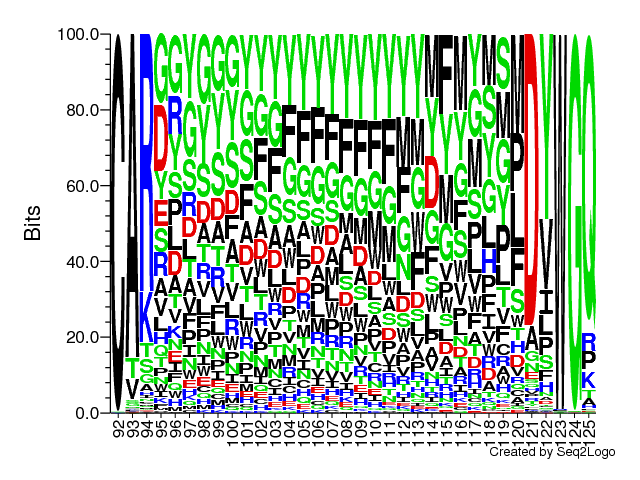

In [9]:
imgpath=str(os.path.join(CONF["lab_book_pics"],"seq_logo_CDRH3.png"))
display.Image(imgpath)

### Storage 

All data file and scripts are stored on the remote server run by Prof. Martin. All programs and figures are also stored on my external hard-drive.

A repository on github contains all relevant files except for the datasets, as these are too large. https://github.com/LilianDenzler/CDR_H3_quality

In the future a python package than can be installed via 
PyPI The Python Package Index will created. 